In [1]:
import tensorflow as tf
import os 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from rbm import RBM, sample
from scipy.stats import bernoulli
from scipy import stats
import pandas as pd

### essential functions

In [2]:
'financial function'
def get_return(Y):
    R = Y.pct_change()[1:]
    return(R)

def get_norm(data):
    mu=data.mean()
    sig=data.std()
    return((data-mu)/sig)

def cumreturn(ret):
    return((1+ret).cumprod())

def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index:(start_index + batch_size)] 


In [3]:
'binarized data set'    
def binarize_1D(X):
    X_int=[]
    X_bin=[]
    x_min=np.min(X)
    x_max=np.max(X)
    N=X.shape[0]
    for k in range(N):
        max_value=2**(16)-1
        x_int=int(max_value*((X[k]-x_min)/(x_max-x_min)))
        x_bin='{0:016b}'.format(x_int)
        x_bin=list(x_bin)
        x_bin=np.array([int(b) for b in x_bin])
        X_int.append(x_int)
        X_bin.append(x_bin)
    return(np.array(X_bin),np.array(X_int))

'de-binarized dataset'    
def bin_to_float(B,min_data,max_data):
    N=B.shape[0]
    max_value=2**(16)-1 
    X_real=[]
    X_int=[]
    for k in range(N):
        x_int=0
        for m in range(16):
            x_int=x_int+ (2**m)*B[k][15-m]
        x_real=min_data+(x_int*(max_data-min_data))/max_value
        X_real.append(x_real)
        X_int.append(x_int)
    return(np.array(X_real))

### VIX/SPX dataset

<a list of 99 Patch objects>

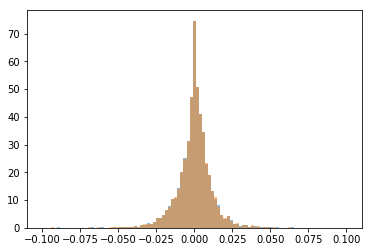

In [4]:
df=pd.read_excel('VIX.xlsx',index_col='Date')
dft=df.T
D_vix=df['VIX']
D_sp=df['SPX 500']



ret=get_return(D_sp)
ret=np.array(ret)
mu_r=ret.mean()
s_r=ret.std()

log_ret=np.log(1+ret)

bins = np.linspace(-0.1, 0.1, 100)
plt.hist(ret, bins,density=True,alpha=0.5)[2]
plt.hist(log_ret, bins,density=True,alpha=0.5)[2]



done


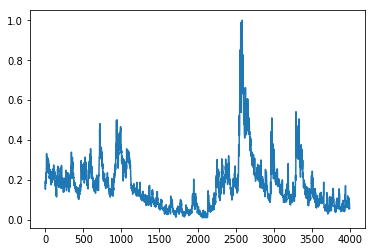

In [5]:
#in case of MinMax Rescaling: data visualisation
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(copy=False)
D_sp_n = scaler.fit_transform(np.array(D_vix).reshape(-1, 1))

D_sp_train=D_sp_n[:4000]
D_sp_test=D_sp_n[4000:]
plt.plot(D_sp_train)

print('done')
type(D_sp_n)

M=D_sp_train


done


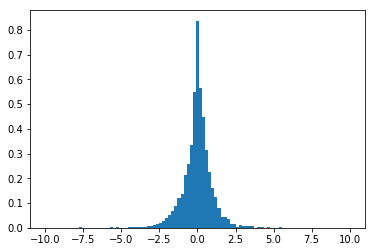

In [6]:
#in case of normalization: data vizualisation
ret_n=get_norm(ret)
bins = np.linspace(-10, 10, 100)
plt.hist(ret_n, bins,density=True)[2]

print('done')

### FX EURUSD Dataset

0.006102704404509735

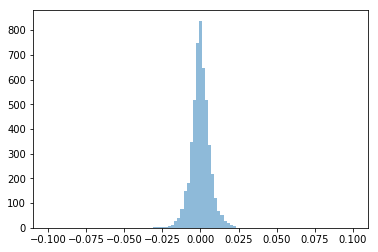

In [7]:
df_fx=pd.read_csv('fx.csv',index_col='Date')
#df_fx=df_fx.sort_index()
df_eurusd=df_fx['Dernier']
df_eurusd=pd.DataFrame([float(a.replace(',','.')) for a in list(df_eurusd)])

ret_fx=get_return(df_eurusd)
r_s=np.sort(np.array(ret_fx).reshape(len(ret_fx),))

bins = np.linspace(-0.1, 0.1, 100)
plt.hist(r_s, bins,alpha=0.5)[2]

ret_fx=np.array(ret_fx).reshape(len(ret_fx),)
ret_fx.std()

### Gaussian mixiture dataset

In [8]:
def gauss_mix(N,pi):
    sample=[]
    for i in range(N):
        delta=int(bernoulli.rvs(pi, loc=0, size=1))
        m_1=np.random.normal(-2, 0.1, size=1)
        m2=np.random.normal(-1.8,0.05 ,size=1)
        mixiture= (1-delta)*m_1+delta*m2
        sample.append(mixiture)
    return(np.array(sample))

M_n=gauss_mix(10000,0.5)


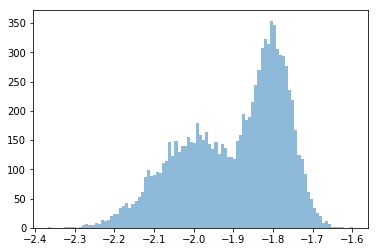

In [9]:
sig=[0.1,0.1]
mu=[-2/1000,3/1000]

M=M_n

def aff_histo(m):
    bins = np.linspace(np.min(m), np.max(m), 100)
    plt.hist(m, bins,alpha=0.5)

aff_histo(M)




### choose your type of data set

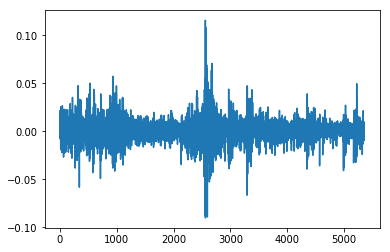

In [39]:
#currency
data=ret_fx
mu_data=data.mean()
sig_data=data.std()
M=get_norm(ret_fx)

#SPX return
M=ret
plt.plot(M)

#gaussian mixiture
#M=M_n
#aff_histo(M)



#M_n=gauss_mix(10000,0.5)
#M=ret=get_return(D_vix).iloc[4500:]
#M=np.array(get_return(D_vix))
#M=np.array(M_n)


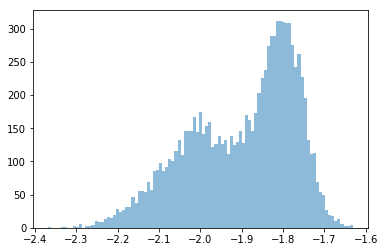

In [12]:
aff_histo(M)

### binarize data-set

In [13]:
M=M.reshape(-1,1)
min_M=np.min(M)
max_M=np.max(M)

B,X_int= binarize_1D(M)   
X=bin_to_float(B,min_M,max_M)


In [14]:
batch_size=100
total_batch=int(len(M) / batch_size)
total_batch



100

#### reseting graph

In [15]:
tf.reset_default_graph()

In [16]:
#first possibility
def pseudo_likelihood(visibles):
    i=0
    x = tf.round(visibles)
    x_fe = rbm_model.free_energy(v=x)
    split0, split1, split2 = tf.split(x, [i, 1, tf.shape(x)[1] - i - 1], 1)
    xi = tf.concat([split0, 1 - split1, split2], 1)
    i = (i + 1) % rbm_model.n_visible
    xi_fe = rbm_model.free_energy(v=xi)
    return tf.reduce_mean(rbm_model.n_visible * tf.log(tf.nn.sigmoid(xi_fe - x_fe)), axis=0)

In [17]:
#second possibility
def change_bit(v):
    v_tilde=v.copy()
    i=np.int(np.random.uniform(0,16,1))
    if v[i]==0:
        v_tilde[i]=1
    else:
        v_tilde[i]=0
    return(v_tilde)

def change_batch(B):
    B_modified=B.copy()
    for i in range(16):
        B_modified[:,i]=change_bit()
        

def sigmoid(x):
    sigm = 1. / (1. + np.exp(-x))
    return(sigm)
    



### RBM model definition + training
Bernouilli mode: sample value following a Bernouilli distribution B(p): p is givnen by sigmoid output. visible/hidden output pass trough sigmoid function //
Gaussian mode:sample value following a Bernouilli distribution N(0,1) without passing data into simoid

In [19]:
tf.reset_default_graph()
# Initialize RBM Model for MNIST reconstruction
rbm_model = RBM(n_visible = 16, n_hidden = 12, lr = tf.constant(0.05, tf.float32), epochs = 2000, mode='bernoulli')
#rbm_model = RBM(n_visible = 784, n_hidden = 144, lr = tf.constant(0.003, tf.float32), epochs = 10000, mode='gaussian')

# Placeholder for the visible layer of the RBM computation graph.
v = tf.placeholder(tf.float32, shape=[None, rbm_model.n_visible], name="visible_layer")


# Update rule
k=1
train_op = rbm_model.update(v, K=k)

#reconstruction: 1 allée-retour dans le RBM
def reconstruction(v,steps=1):
    for i in range(steps):
        hidden_p=rbm_model.get_probabilities('hidden', v)
        h_state = sample(hidden_p)
        visible_p=rbm_model.get_probabilities('visible', h_state)
        v=sample(visible_p)
    return(v)

# Free energy
energy = rbm_model.free_energy(v=v)
tf.summary.scalar('free_energy', tf.reduce_mean(energy))

# Merge summaries for Tensorboard visualization
summary = tf.summary.merge_all()

# Create session.
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


Evol=[]
FE=[]

for epoch in tqdm(range(rbm_model.epochs)):
    if epoch % 200== 0:
        test_set=B
        result = sess.run([rbm_model.rec_error, summary], feed_dict = {v: test_set})
        B_sample_int=sess.run(reconstruction(v),feed_dict={v: B})
        M_sample_int=bin_to_float(B_sample_int,min_M,max_M)
        M_sample_int=pd.DataFrame(M_sample_int)
        Evol.append(M_sample_int)
        if epoch % 200 == 0: print("Reconstruction error at step {}: {:.3f}".format(epoch, result[0]))
            #print(fee_e)
        #test_writer.add_summary(result[1],epoch)
    total_batch = int(len(M) / batch_size)
    avg_ll=0

    for i in range(total_batch):
        batchXs=get_random_block_from_data(B, batch_size)
        sess.run(train_op, feed_dict = {v: batchXs})
        #free_e=sess.run(energy, feed_dict = {v: batchXs})
        #avg_fe+=free_e/len(M) *batch_size
        #PL=sess.run(pseudo_likelihood(v),feed_dict = {v: batchXs})

    
        




C:\Users\xu\Programs\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

Reconstruction error at step 0: 0.337


 10%|███████▊                                                                       | 198/2000 [00:08<01:06, 27.03it/s]

Reconstruction error at step 200: 0.080


 20%|███████████████▊                                                               | 399/2000 [00:17<01:06, 24.17it/s]

Reconstruction error at step 400: 0.067


 30%|███████████████████████▋                                                       | 600/2000 [00:26<00:57, 24.17it/s]

Reconstruction error at step 600: 0.055


 40%|███████████████████████████████▌                                               | 798/2000 [00:34<00:49, 24.23it/s]

Reconstruction error at step 800: 0.054


 50%|███████████████████████████████████████▍                                       | 998/2000 [00:43<00:38, 26.12it/s]

Reconstruction error at step 1000: 0.054


 60%|██████████████████████████████████████████████▊                               | 1200/2000 [00:52<00:32, 24.57it/s]

Reconstruction error at step 1200: 0.054


 70%|██████████████████████████████████████████████████████▌                       | 1399/2000 [01:00<00:24, 24.70it/s]

Reconstruction error at step 1400: 0.053


 80%|██████████████████████████████████████████████████████████████▎               | 1598/2000 [01:09<00:16, 23.72it/s]

Reconstruction error at step 1600: 0.053


 90%|██████████████████████████████████████████████████████████████████████▏       | 1800/2000 [01:18<00:08, 24.62it/s]

Reconstruction error at step 1800: 0.053


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:27<00:00, 22.85it/s]


In [33]:
np.min(X.flatten() - M.flatten())

-1.122899969296931e-05

### visualize the training process

In [20]:
Evol=pd.concat([pd.DataFrame(Evol[i]) for i in range(len(Evol))],axis=1)


In [21]:
Evol_tab=np.array(Evol)
Evol_tab.shape

(10000, 10)

C:\Users\rochej\AppData\Local\Continuum\anaconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


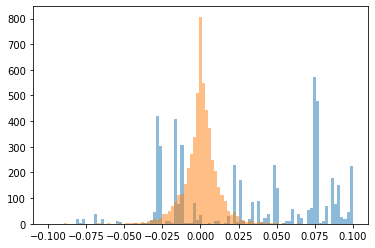

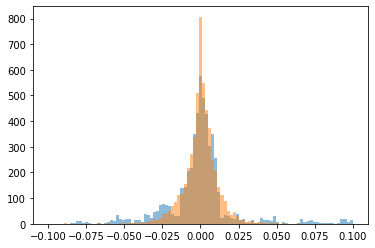

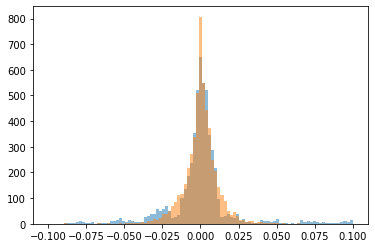

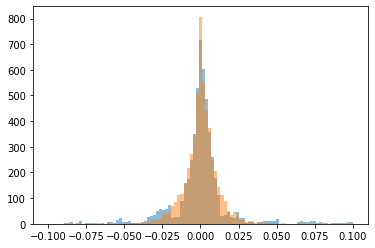

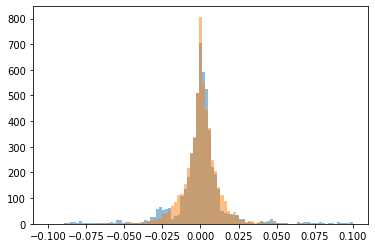

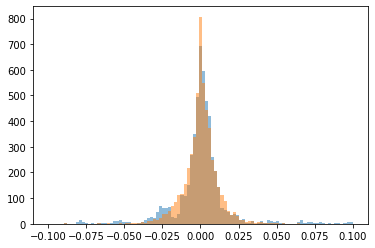

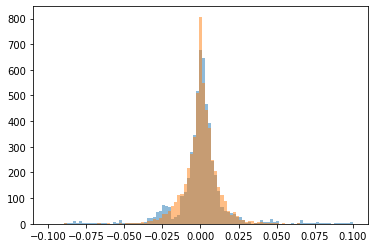

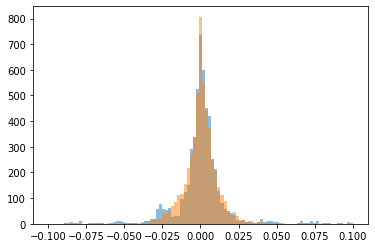

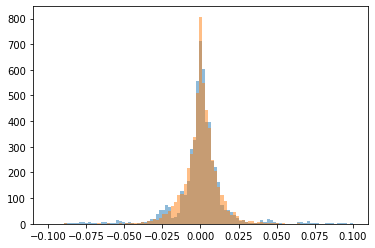

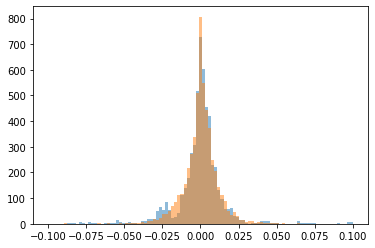

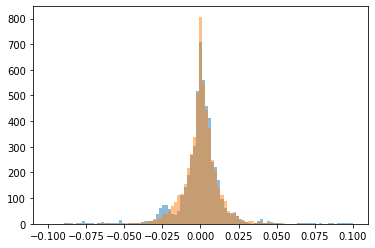

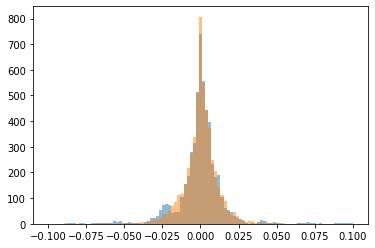

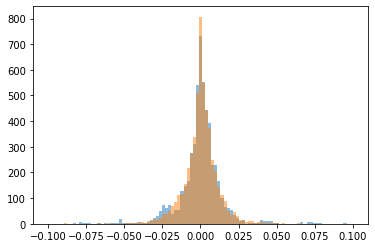

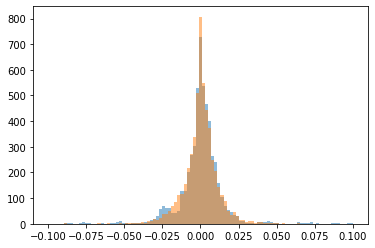

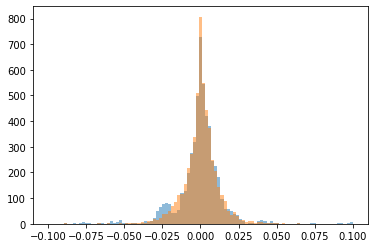

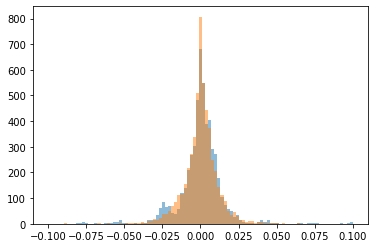

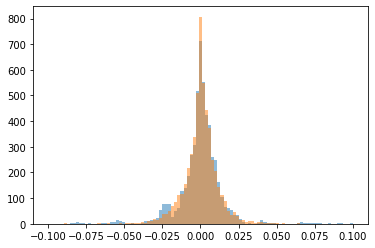

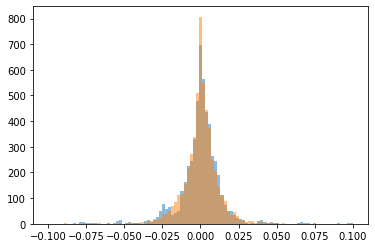

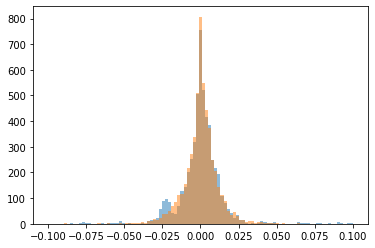

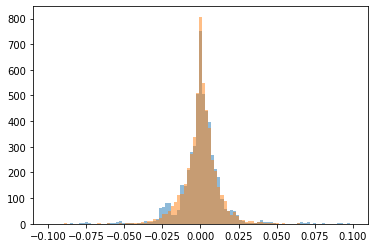

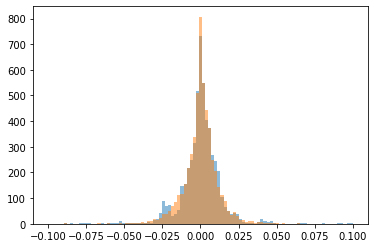

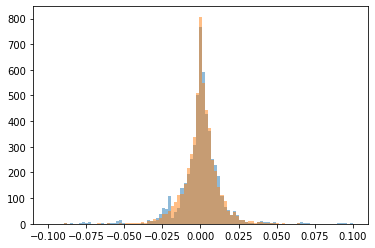

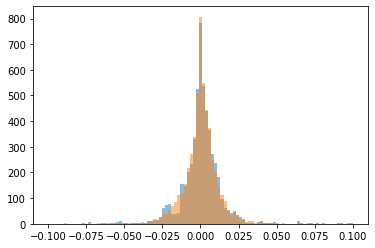

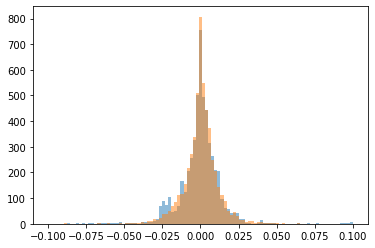

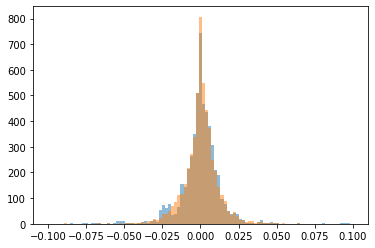

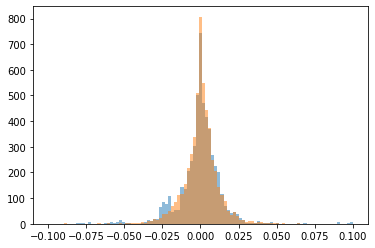

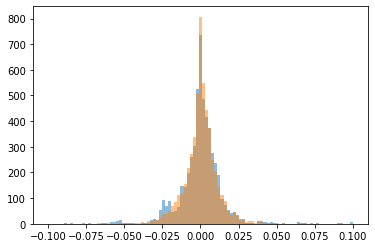

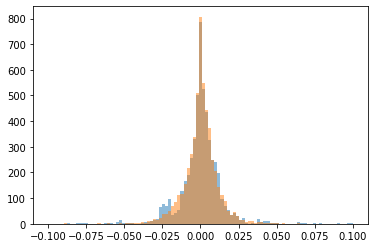

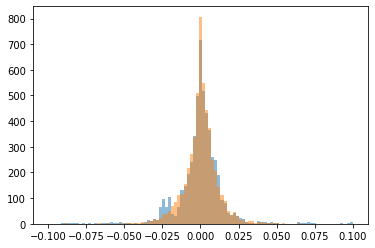

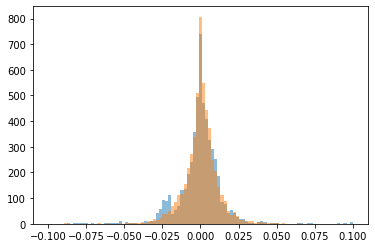

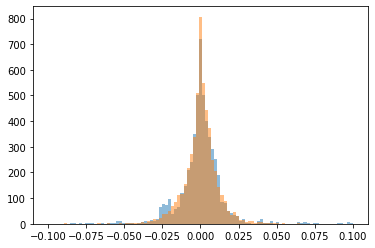

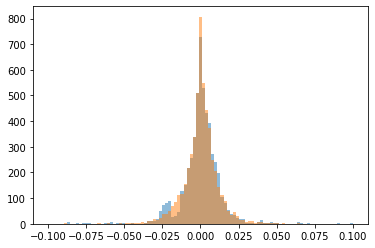

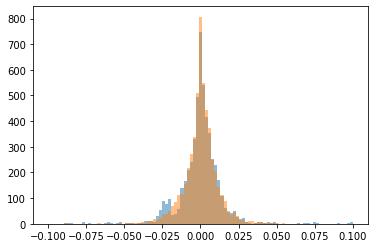

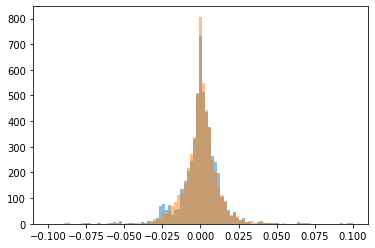

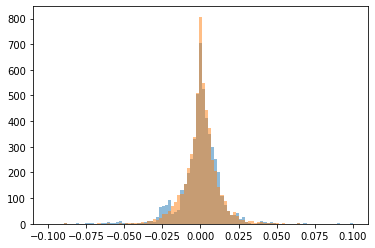

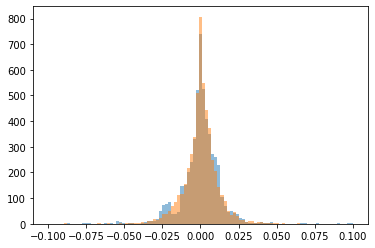

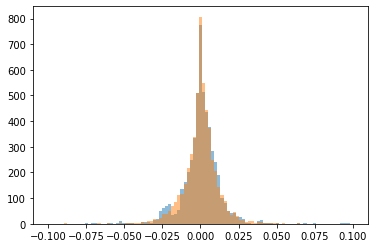

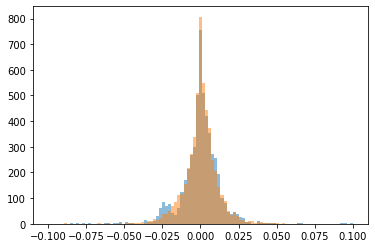

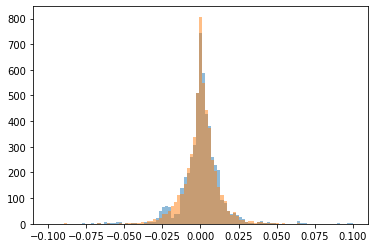

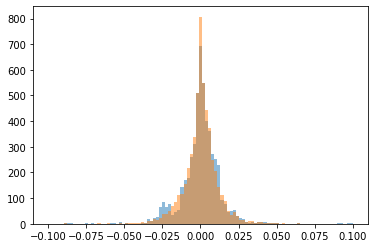

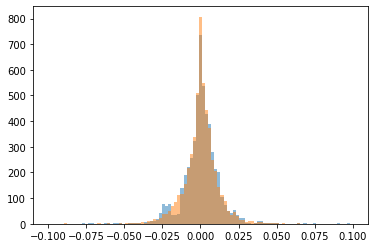

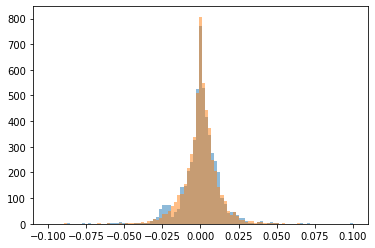

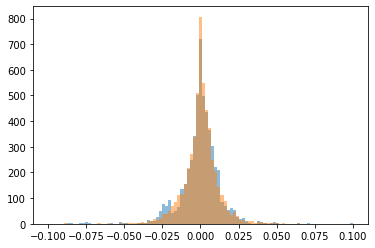

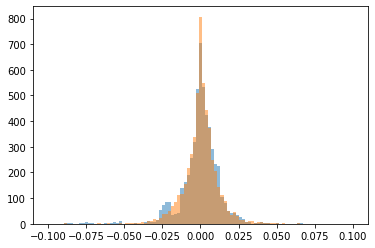

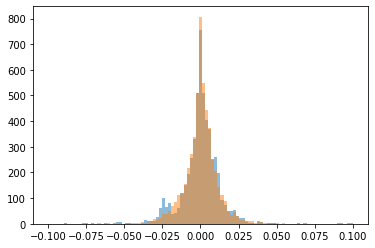

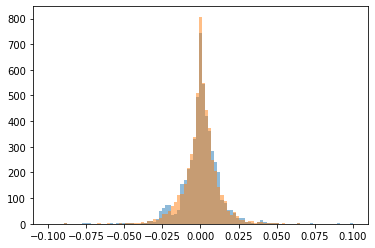

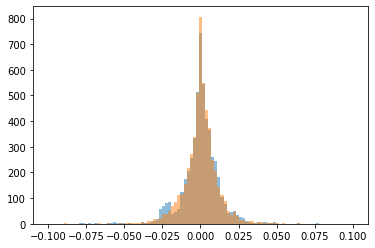

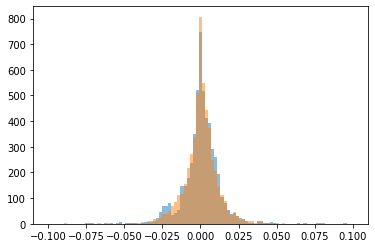

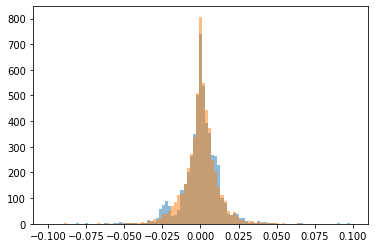

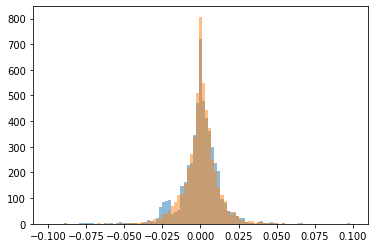

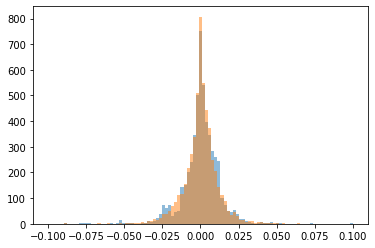

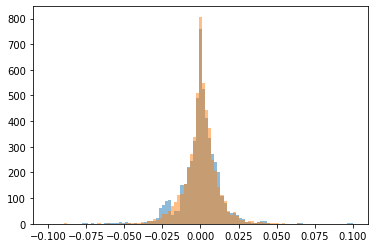

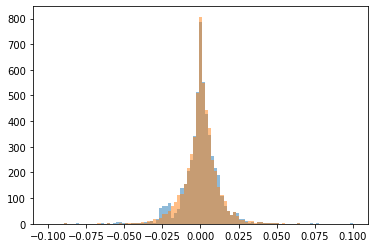

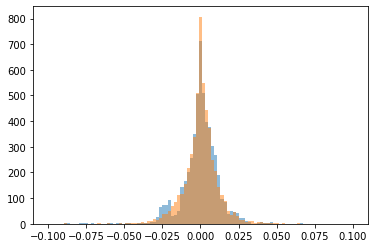

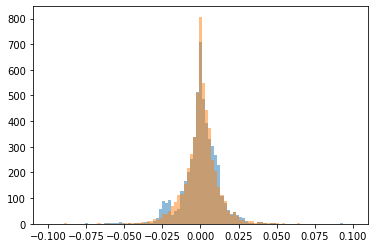

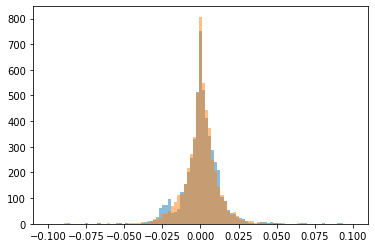

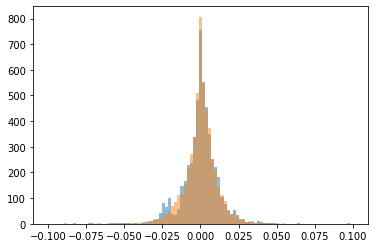

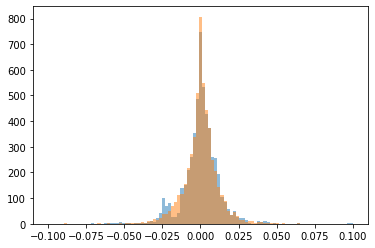

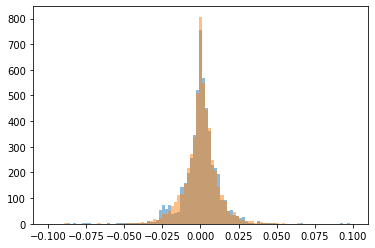

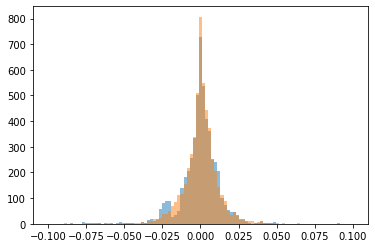

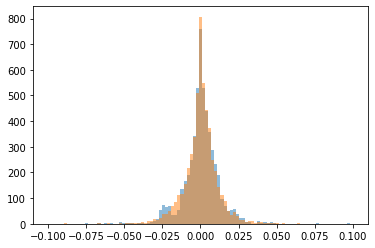

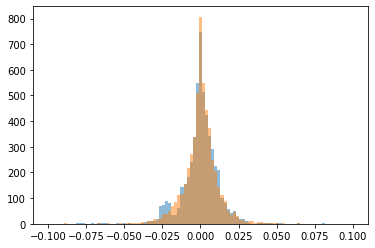

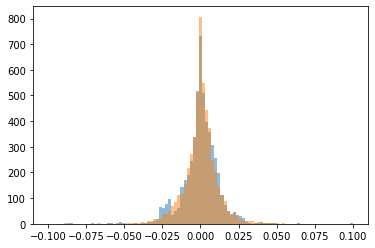

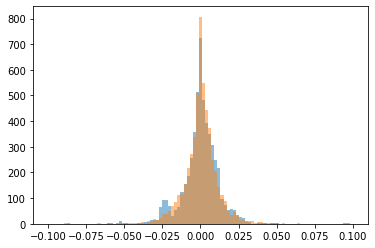

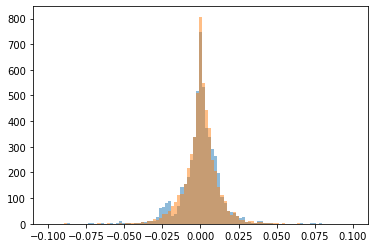

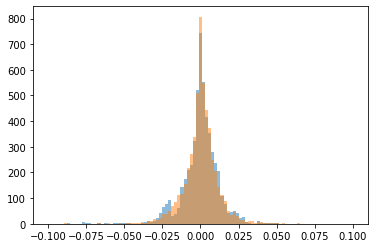

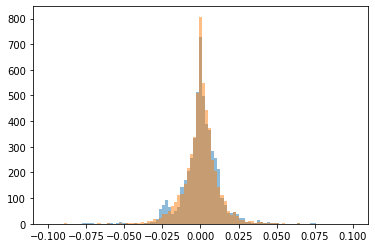

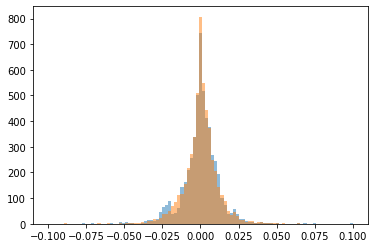

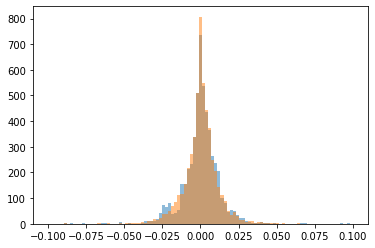

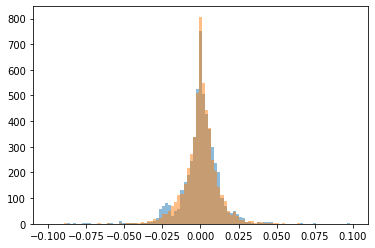

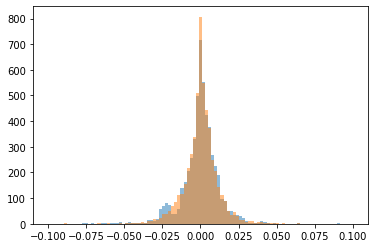

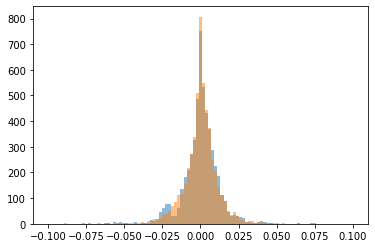

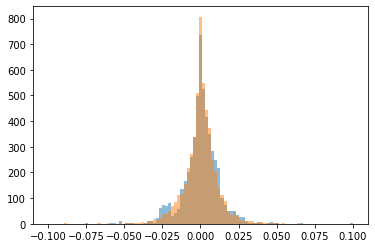

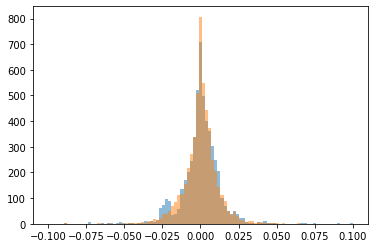

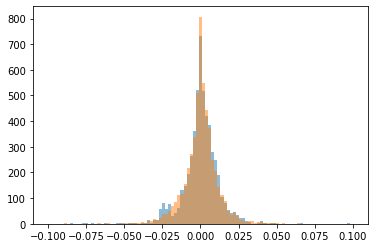

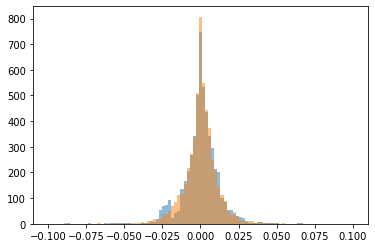

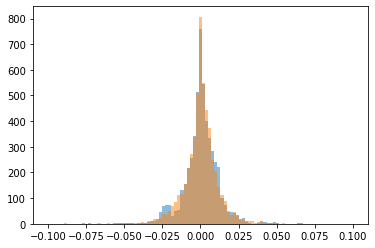

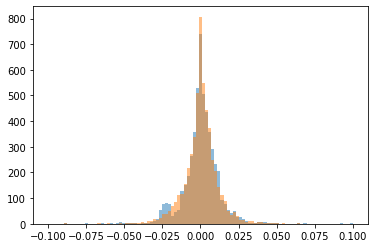

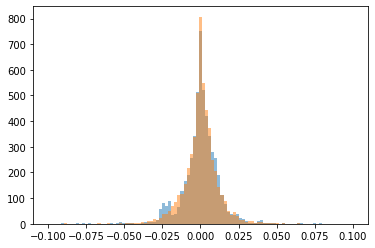

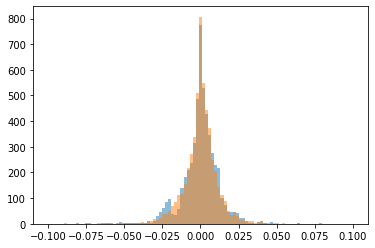

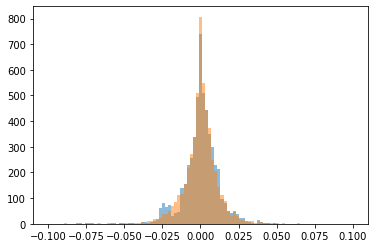

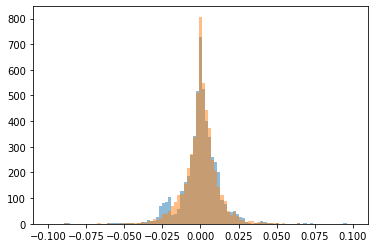

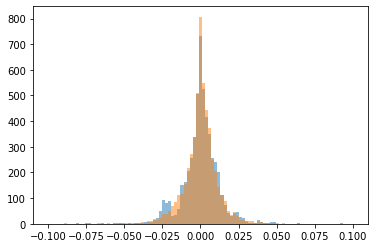

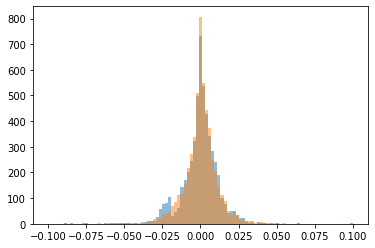

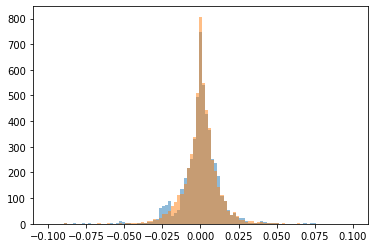

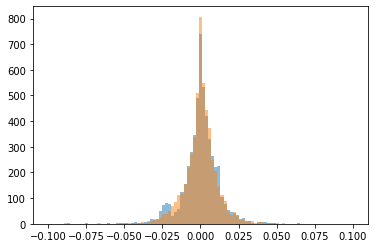

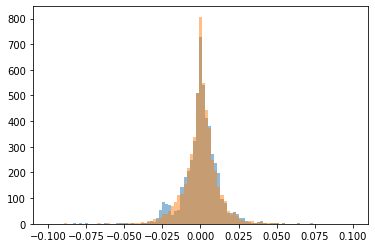

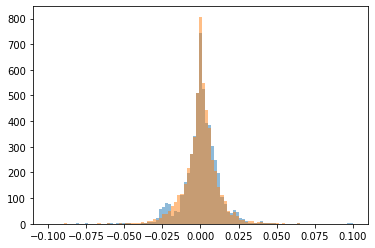

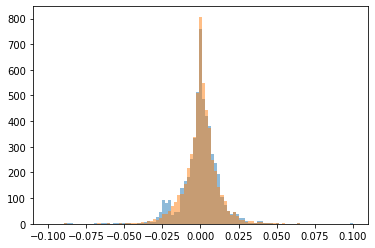

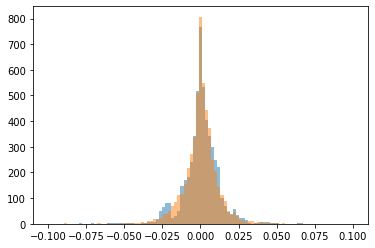

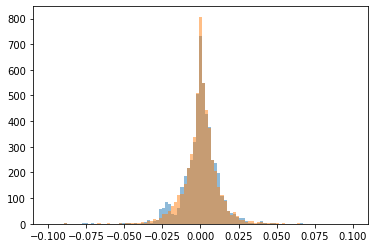

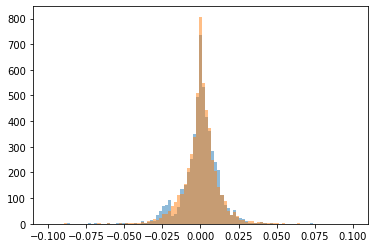

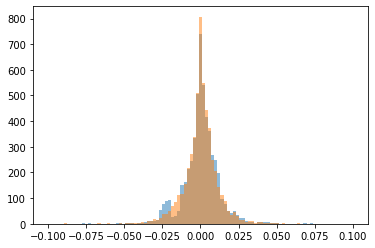

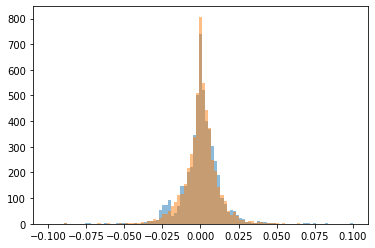

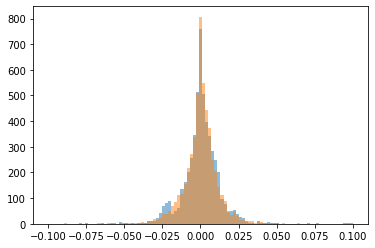

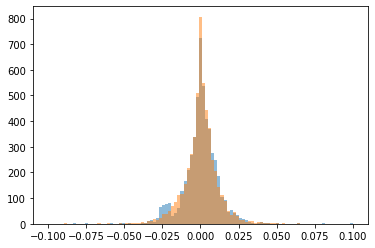

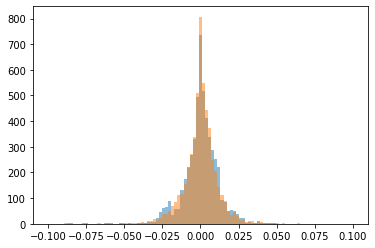

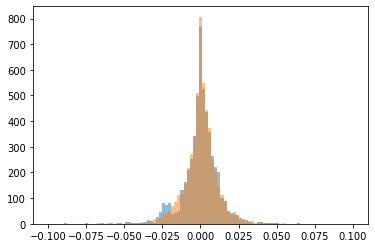

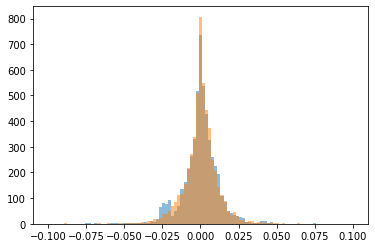

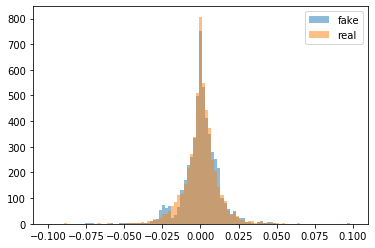

In [41]:

bins = np.linspace(-0.1, 0.1, 100)
for i in range(Evol_tab.shape[1]):
    plt.figure()
    plt.hist(Evol_tab[:,i], bins,alpha=0.5,label='fake')[2]
    plt.hist(M, bins,alpha=0.5,label='real')[2]
plt.legend()

C:\Users\rochej\AppData\Local\Continuum\anaconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


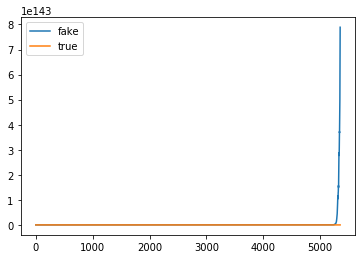

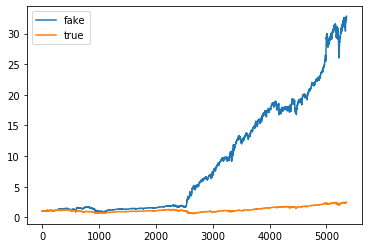

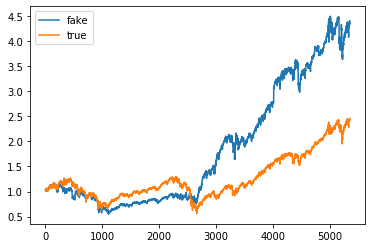

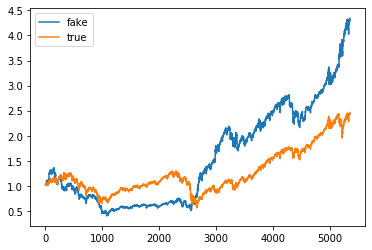

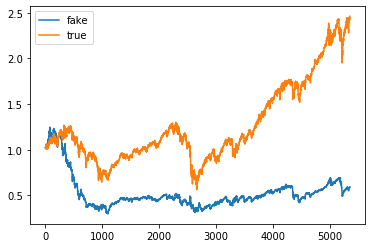

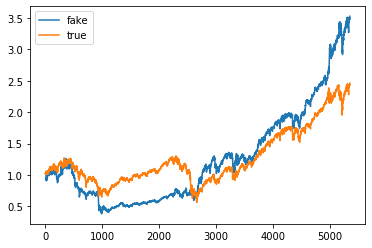

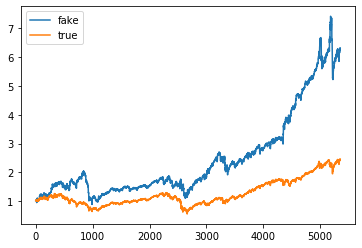

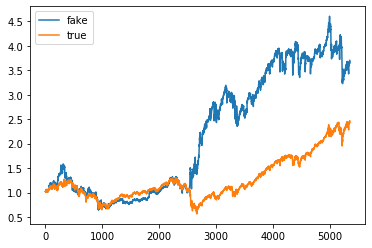

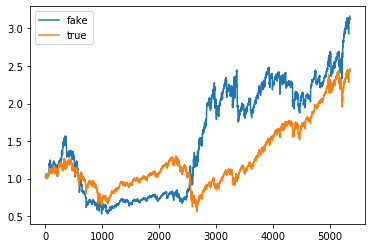

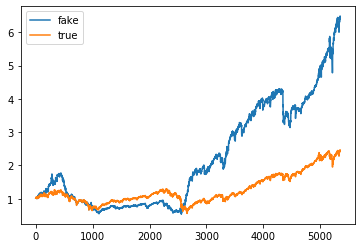

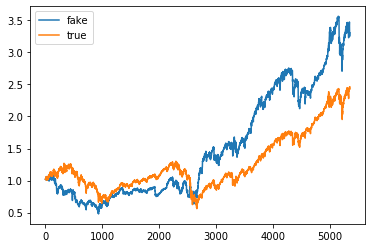

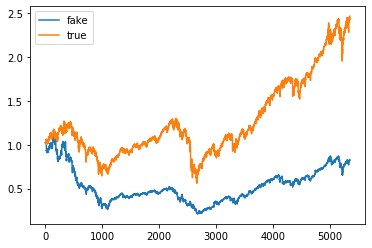

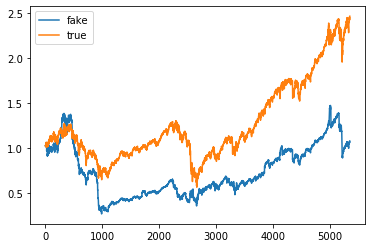

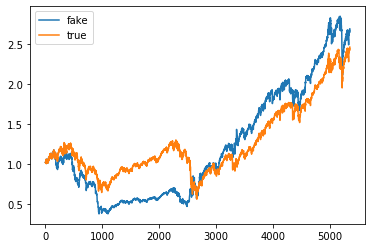

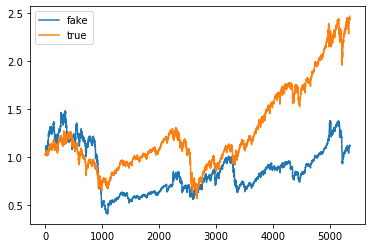

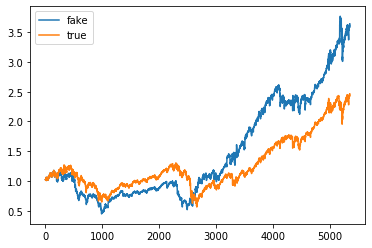

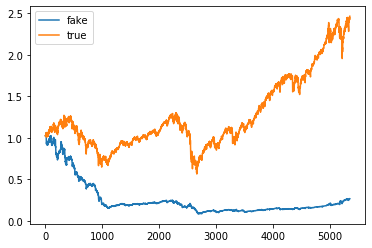

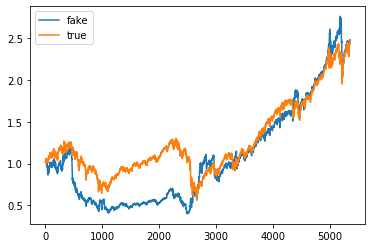

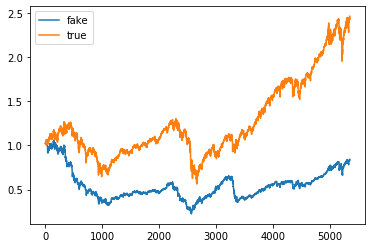

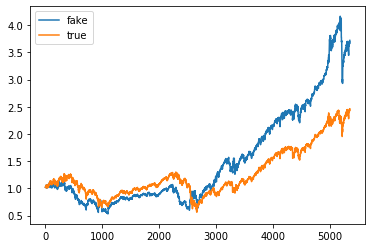

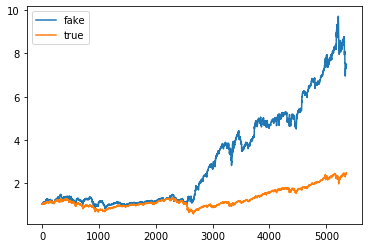

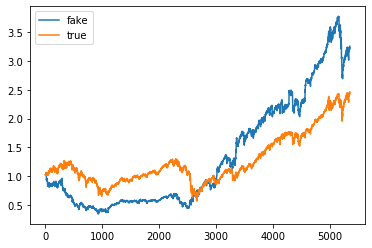

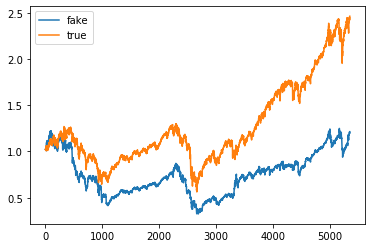

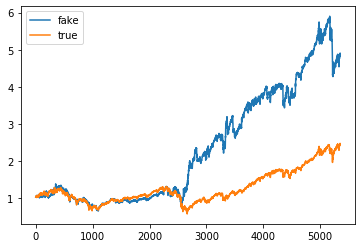

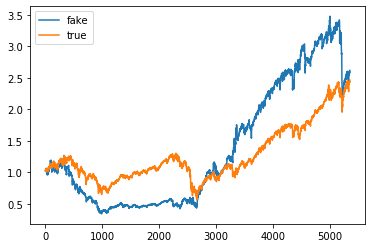

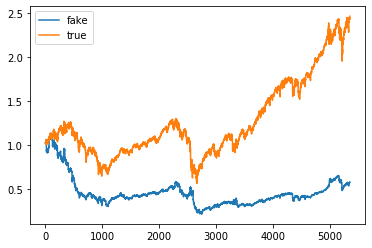

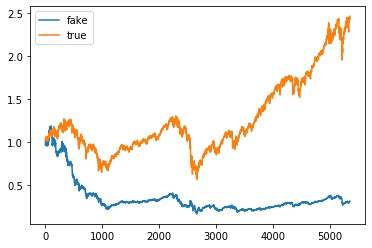

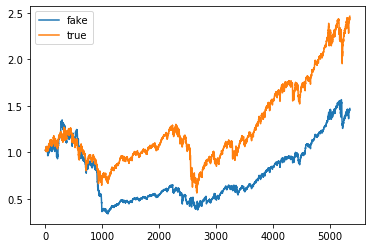

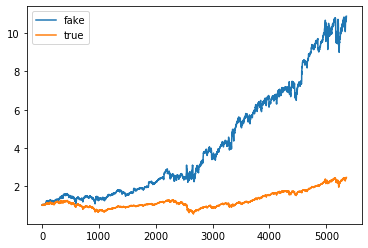

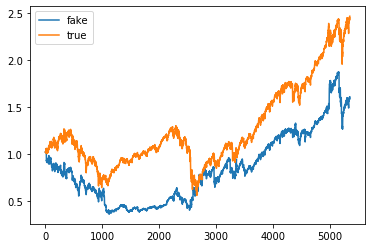

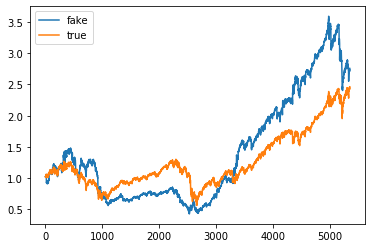

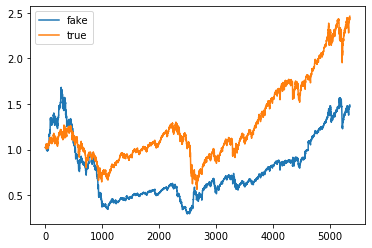

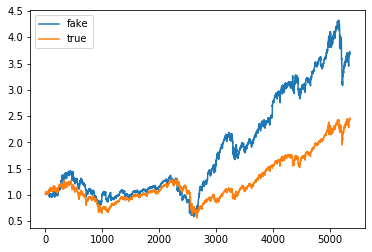

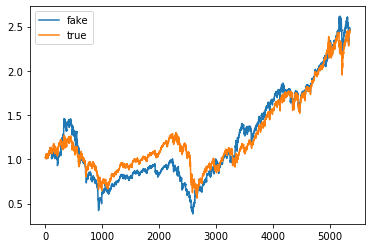

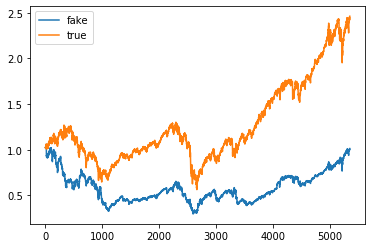

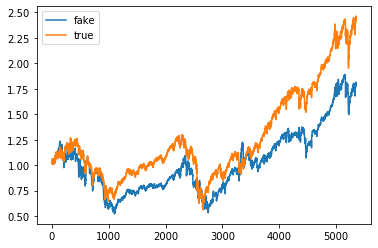

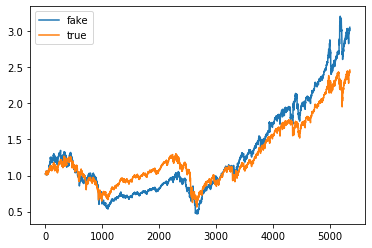

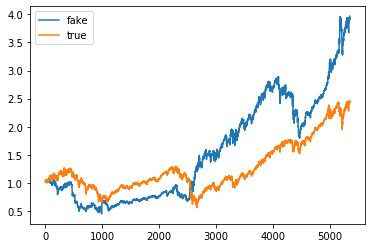

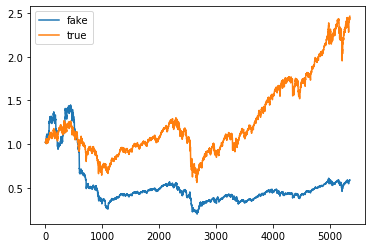

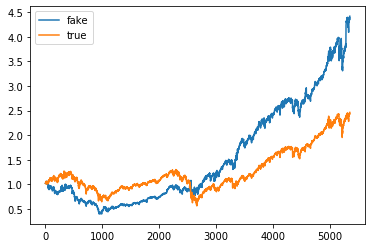

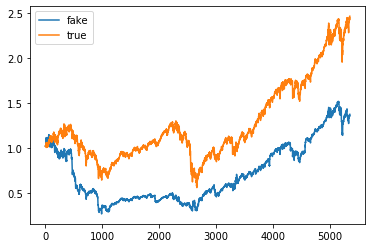

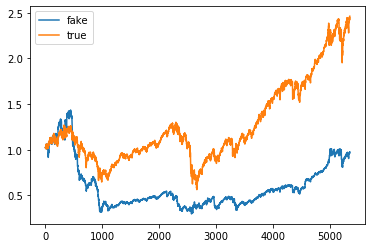

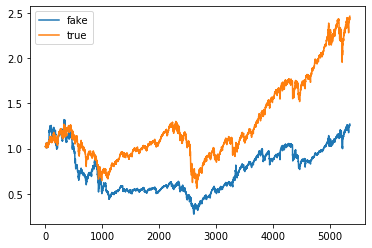

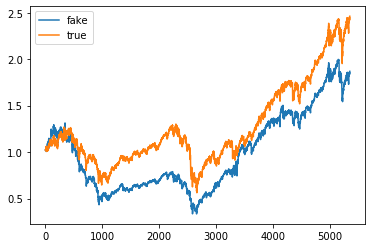

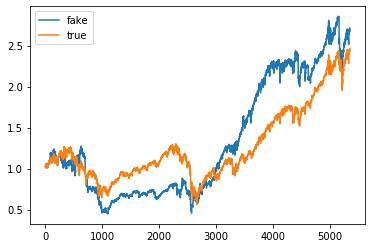

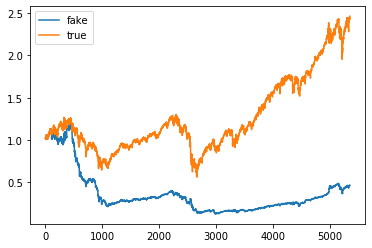

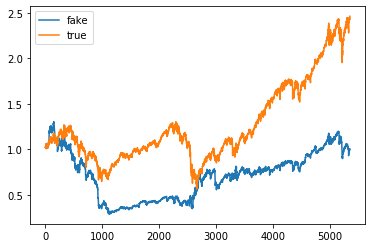

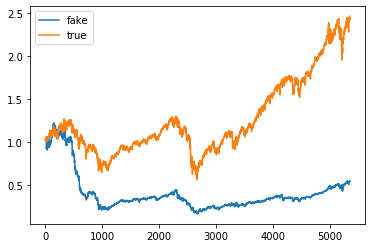

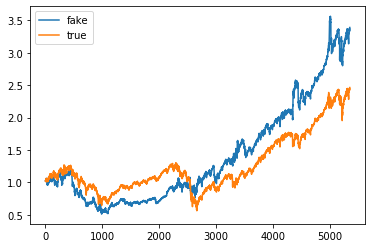

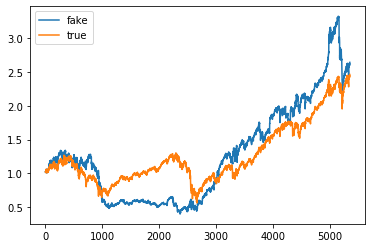

In [16]:
u_true=pd.DataFrame(M)

for i in range(Evol_tab.shape[1]):
    u_fake=pd.DataFrame(Evol_tab[:,i])
    plt.figure()
    plt.plot(cumreturn(u_fake),label='fake')
    plt.plot(cumreturn(u_true),label='true')
    plt.legend()


In [ ]:
for i in range(Evol_tab.shape[1]):
    print(i)
    u_fake=pd.DataFrame(Evol_tab[:,i])

    xt=np.array(u_true).reshape(len(u_true),)
    yt=np.array(u_fake).reshape(len(u_fake),)
    p_value=stats.ks_2samp(xt, yt)[1]
    print('pvalue',stats.ks_2samp(xt, yt)[1])
    if p_value<0.05:
        print('same distribution')
    else:
        print('not the same distribution')

In [ ]:
i=Evol_tab.shape[1]
u_fake=pd.DataFrame(Evol_tab[:,1])
xt=np.array(u_true).reshape(len(u_true),)
yt=np.array(u_fake).reshape(len(u_fake),)
p_value=stats.ks_2samp(xt, yt)[1]
print('pvalue',stats.ks_2samp(xt, yt)[1])
if p_value<0.05:
    print('same distribution')
else:
    print('not the same distribution')
plt.plot(cumreturn(u_fake),label='fake')
plt.plot(cumreturn(u_true),label='true')

### sampling fake Data

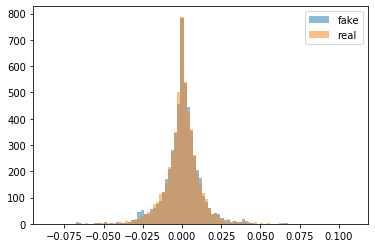

In [201]:

B_sample=sess.run(reconstruction(v,1),feed_dict={v: B})
M_sample=bin_to_float(B_sample,min_M,max_M)

bins = np.linspace(np.min(M_sample), np.max(M_sample), 100)
plt.hist(M_sample, bins,alpha=0.5,label='fake')[2]
plt.hist(M, bins,alpha=0.5,label='real')[2]
plt.legend()
plt.savefig('result_latex/graphr_1.png')

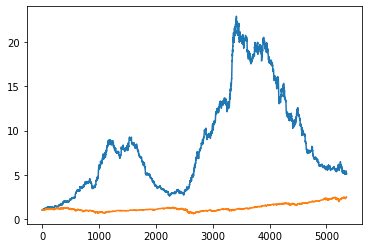

In [202]:
u_f=pd.DataFrame(M_sample)
u_t=pd.DataFrame(ret)
plt.plot(cumreturn(u_f))
plt.plot(cumreturn(u_t))

## Test: new type of generation

In [23]:
def autocorr_gene(start,N_gene):
    init=B[start]
    init=init.reshape(-1,1).T
    sample=[bin_to_float(init,min_M,max_M)]
    b=init
    for k in range(N_gene):
        b=sess.run(reconstruction(v,100),feed_dict={v: b})
        s=bin_to_float(b,min_M,max_M)
        sample.append(s)
        print(k)
    return(np.array(sample))
        
        
S=autocorr_gene(0,100)       

0
1
2
3
4
5


KeyboardInterrupt: 

In [24]:
fig = plt.figure()
plt.plot(S,label='false')
T=M[:101]
plt.plot(T,label='true')


NameError: name 'S' is not defined

<Figure size 432x288 with 0 Axes>

In [25]:
print(S.std())
print(S.mean())

NameError: name 'S' is not defined

In [28]:
print(T.std())
print(T.mean())


0.011895357659031169
0.001310310686299516


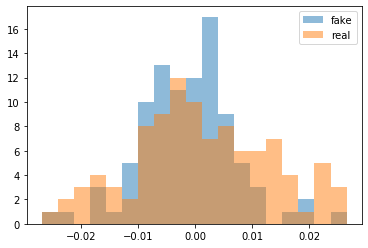

In [29]:
bins = np.linspace(np.min(T), np.max(T), 20)
plt.hist(S, bins,alpha=0.5,label='fake')[2]
plt.hist(T, bins,alpha=0.5,label='real')[2]
plt.legend()
plt.savefig('results/1sampling_hist.png')

(5354,)

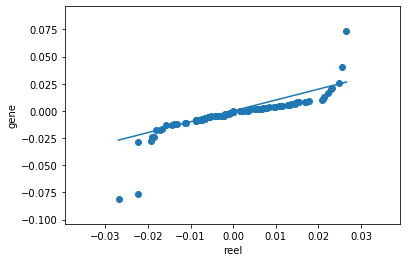

In [30]:
plt.scatter(np.sort(T.reshape(-1,)), np.sort(S.reshape(-1,)))
x=np.array([np.min(T),np.max(T)])
y=np.array([np.min(T),np.max(T)])
plt.plot(x,y)
plt.xlabel('reel')
plt.ylabel('gene')
M_sample.shape

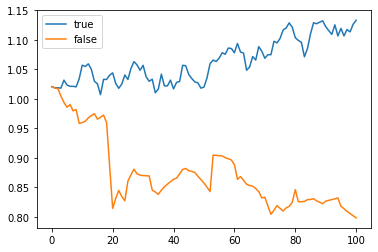

In [31]:
u_t=pd.DataFrame(T)
u_s=pd.DataFrame(S)
plt.plot(cumreturn(u_t),label='true')
plt.plot(cumreturn(u_s),label='false')
plt.legend()

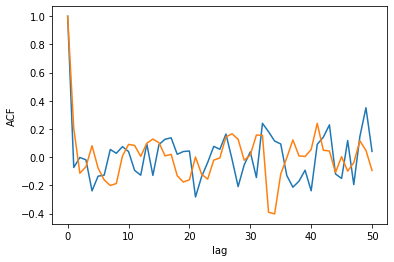

In [40]:
def aff_autocorr(n_lag,s):
    A=[]

    for k in range(0,n_lag+1):
        A.append(s.autocorr(lag=k))

    Ad=pd.Series(A)
    x=np.array([i for i in range(0,n_lag+1)])
    plt.plot(x,A)
    plt.xlabel('lag')
    plt.ylabel('ACF')



S=pd.concat([(u_t),(u_s)],axis=1)
S.columns=['true','fake']
aff_autocorr(50,S['true'])
aff_autocorr(50,S['fake'])

In [36]:
u_s.shape

(101, 1)

## Test thermalisation
1. si m_1=N(0,0.01) apres K=5000: on retrouve la distrib// pre-trained RBM avec epoch=1000


10000

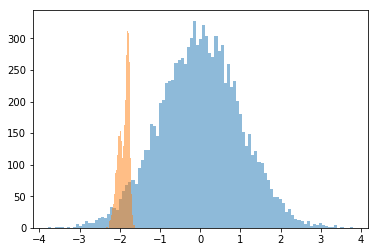

In [35]:
m_1=np.random.normal(0,1, size=B.shape[0])
m_2=np.random.normal(0,1, size=B.shape[0])
aff_histo(m_1)
aff_histo(M)
B.shape[0]

In [40]:
B_sample_1

array([[1., 1., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 1., 1.],
       [1., 0., 1., ..., 0., 0., 1.]], dtype=float32)

In [36]:


M_1=m_1.reshape(-1,1)
min_M_1=np.min(M_1)
max_M_1=np.max(M_1)

B_1,X_int_1= binarize_1D(M_1)   
X_1=bin_to_float(B_1,min_M,max_M)

B_sample_1=sess.run(reconstruction(v,steps=5000),feed_dict={v: B_1})
M_sample_1=bin_to_float(B_sample_1,min_M,max_M)






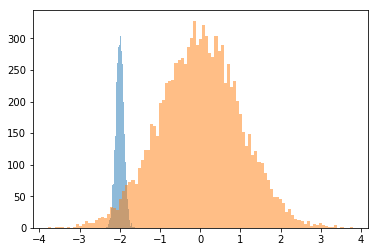

In [37]:
X_1=bin_to_float(B_1,min_M,max_M)
aff_histo(X_1)
aff_histo(m_1)

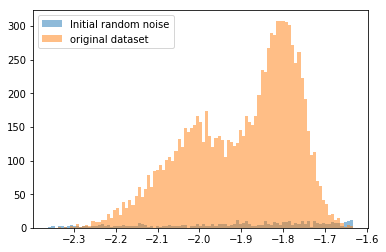

In [38]:

bins = np.linspace(np.min(M_sample_1), np.max(M_sample_1), 100)
#plt.hist(M_1, bins,alpha=0.5,label='ini')[2]
plt.hist(m_1, bins,alpha=0.5,label='Initial random noise')[2]
plt.hist(M, bins,alpha=0.5,label='original dataset')[2]

plt.legend()


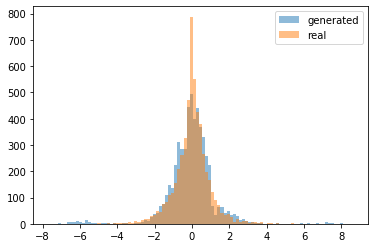

In [116]:
bins = np.linspace(np.min(M_sample_1), np.max(M_sample_1), 100)
#plt.hist(M_1, bins,alpha=0.5,label='ini')[2]
plt.hist(M_sample_1, bins,alpha=0.5,label='generated')[2]
plt.hist(M, bins,alpha=0.5,label='real')[2]

plt.legend()
#plt.savefig('result_latex/graphs2_10.png')

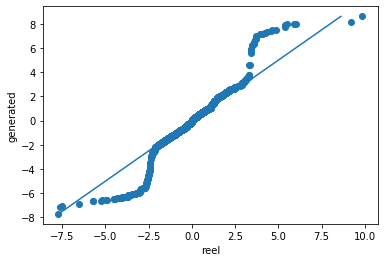

In [118]:
M_t=M.reshape(M.shape[0],)
M_t.shape

plt.scatter(np.sort(M_t), np.sort(M_sample_1))
x=np.array([np.min(M_sample_1),np.max(M_sample_1)])
y=np.array([np.min(M_sample_1),np.max(M_sample_1)])
plt.plot(x,y)
plt.xlabel('reel')
plt.ylabel('generated')

plt.savefig('result_latex/graphqqs_5000.png')

Text(0, 0.5, 'random noise')

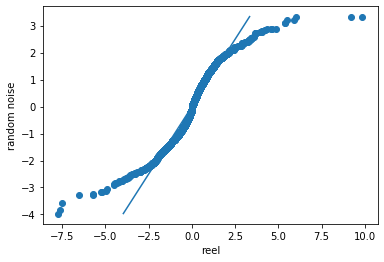

In [93]:
M_t=M.reshape(M.shape[0],)
M_t.shape

plt.scatter(np.sort(M_t), np.sort(m_1))
x=np.array([np.min(m_1),np.max(m_1)])
y=np.array([np.min(m_1),np.max(m_1)])
plt.plot(x,y)
plt.xlabel('reel')
plt.ylabel('random noise')
#plt.savefig('result_latex/graphqq2.png')

### QQ plot

Text(0, 0.5, 'gene')

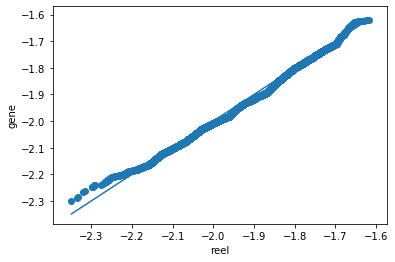

In [164]:
M_t=M.reshape(M.shape[0],)
M_t.shape

plt.scatter(np.sort(M_t), np.sort(M_sample_1))
x=np.array([np.min(M_t),np.max(M_t)])
y=np.array([np.min(M_t),np.max(M_t)])
plt.plot(x,y)
plt.xlabel('reel')
plt.ylabel('gene')

Text(0, 0.5, 'normal')

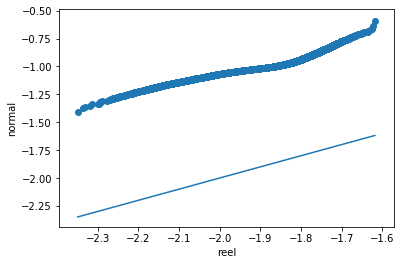

In [165]:
plt.scatter(np.sort(M_t), np.sort(m_1))
x=np.array([np.min(M_t),np.max(M_t)])
y=np.array([np.min(M_t),np.max(M_t)])
plt.plot(x,y)
plt.xlabel('reel')
plt.ylabel('normal')

In [120]:
print(np.percentile(M_t, 1))
print(np.percentile(M_sample_1, 1))
print(np.percentile(m_1, 1))
print(np.percentile(M_t, 99))
print(np.percentile(M_sample_1, 99))
print(np.percentile(m_1, 99))

-2.78029293717033
-5.577094542067469
-2.3399021325357303
2.8777673364417873
2.9575174423166013
2.27872473225902


In [121]:
print(np.mean(M_t))
print(np.mean(M_sample_1))

-1.3271250200973108e-17
-0.03513740377872916


In [122]:
print(np.std(M_t))
print(np.std(M_sample_1))

1.0
1.2966773948563832


In [119]:
xt=M_t
yt=M_sample_1
p_value=stats.ks_2samp(xt, yt)[1]
print('pvalue',stats.ks_2samp(xt, yt)[1])
if p_value<0.1:
    print('same distribution')

pvalue 5.354217496821891e-09
same distribution


In [32]:
xt=M_t
yt_init=m_1
p_value=stats.ks_2samp(M_t, m_1)[1]
print('pvalue',stats.ks_2samp(M_t, m_1)[1])
if p_value<0.1:
    print('same distribution')
else:
    print('not the same distribution')

pvalue 0.0
same distribution


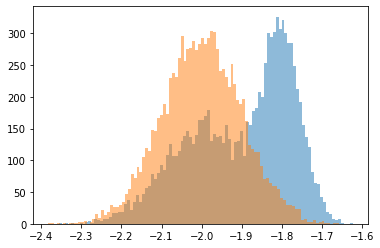

In [33]:
aff_histo(M_t)
aff_histo(m_1)

In [179]:
from scipy.stats import wasserstein_distance

print(wasserstein_distance(M_t, M_sample_1))
print(wasserstein_distance(M_t, m_1))

0.00849788804834501
0.8999143634284695


In [62]:
from scipy.stats import wasserstein_distance
wasserstein_distance(m_1, M_sample_1)
wasserstein_distance(M_t, M_sample_1)
wasserstein_distance(M_t, m_1)

0.09901732591416572

In [61]:
noise=np.random.normal(0,0.001,size=M_t.shape)
M_noise=M_t+noise
M_noise.shape
wasserstein_distance(M_t, M_noise)

0.00015501350987886253

### Simulation

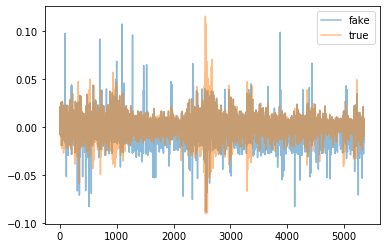

In [173]:

u_true=pd.DataFrame(M)
u_fake=pd.DataFrame(M_sample)
plt.plot(u_fake,alpha=0.5,label='fake')
plt.plot(u_true,alpha=0.5,label='true')
plt.legend()
R_tot=pd.concat([u_true,u_fake],axis=1)
plt.savefig('result_latex/graphr_2.png')

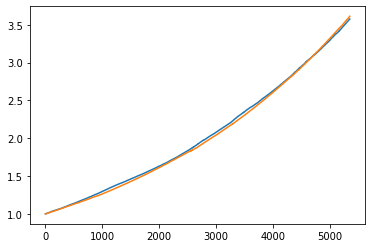

In [203]:
#in case of normalisation
ret_true=s_r*M+mu_r
ret_fake=s_r*u_fake+mu_r

plt.plot(cumreturn(ret_fake))
plt.plot(cumreturn(ret_true))

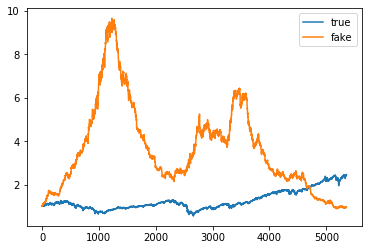

In [204]:
plt.plot(cumreturn(u_true),label='true')
plt.plot(cumreturn(u_fake),label='fake')
plt.legend()

F=pd.concat([cumreturn(u_true),cumreturn(u_fake)],axis=1)
F_r=pd.concat([u_true,u_fake],axis=1)
u_fake.to_csv('fake.csv')


In [151]:
print('true_std=',u_true.std())
print('fake_std=',u_fake.std())

true_std= 0    1.000093
dtype: float64
fake_std= 0    1.149337
dtype: float64


In [152]:
print('true_mean=',u_true.mean())
print('fake_mean=',u_fake.mean())

true_mean= 0   -1.327125e-17
dtype: float64
fake_mean= 0   -0.007919
dtype: float64


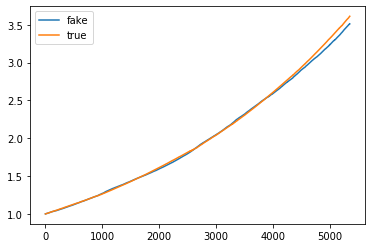

In [205]:

for _ in range(1):
    B_sample=sess.run(reconstruction(v),feed_dict={v: B})
    M_sample=bin_to_float(B_sample,min_M,max_M)
    u_fake=pd.DataFrame(M_sample)
    ret_fake=s_r*u_fake+mu_r
    plt.plot(cumreturn(ret_fake),label='fake')
    
plt.plot(cumreturn(ret_true),label='true')
plt.legend()

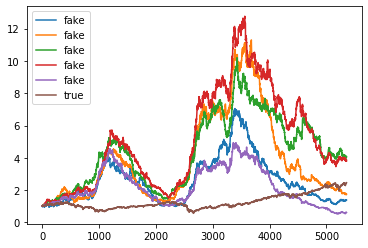

In [207]:
for _ in range(5):
    B_sample=sess.run(reconstruction(v),feed_dict={v: B})
    M_sample=bin_to_float(B_sample,min_M,max_M)
    u_fake=pd.DataFrame(M_sample)
    plt.plot(cumreturn(u_fake),label='fake')
    
plt.plot(cumreturn(u_true),label='true')
plt.legend()


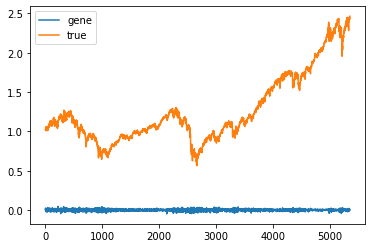

In [67]:
def simulate_mean_data(n_sim):
    L=[]
    for k in range(n_sim):
        B_sample=sess.run(reconstruction(v),feed_dict={v: B})
        M_sample=bin_to_float(B_sample,min_M,max_M)
        u_fake=pd.DataFrame(M_sample)
        L.append(u_fake)
        u_fake=cumreturn(u_fake)
        #L.append(u_fake)
        #plt.plot(u_fake)
    X=pd.concat([L[i] for i in range(len(L))],axis=1)
    X_mean=X.mean(axis=1)
    plt.plot(X_mean,label='gene')  
    plt.plot(cumreturn(u_true),label='true')
    plt.legend()
    return(X)


X=simulate_mean_data(30)

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

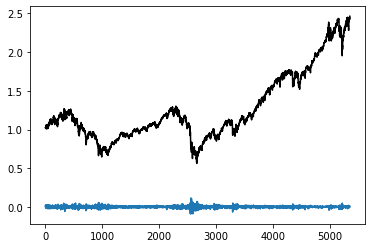

In [61]:
plt.plot(X)
plt.plot(cumreturn(u_true),color='black')
X.to_csv('fake30_spx.csv')

In [69]:
X.to_csv('fakeret30_spx.csv')

### Autocorrelation

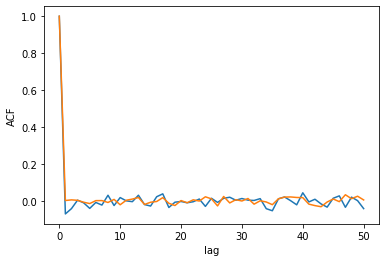

In [76]:
def aff_autocorr(n_lag,s):
    A=[]

    for k in range(0,n_lag+1):
        A.append(s.autocorr(lag=k))

    Ad=pd.Series(A)
    x=np.array([i for i in range(0,n_lag+1)])
    plt.plot(x,A)
    plt.xlabel('lag')
    plt.ylabel('ACF')


S=pd.concat([cumreturn(u_true),cumreturn(u_fake)],axis=1)
S=pd.concat([(u_true),(u_fake)],axis=1)
S.columns=['true','fake']
aff_autocorr(50,S['true'])
aff_autocorr(50,S['fake'])


### Kolmo smirnov test

In [77]:

xt=np.array(u_true).reshape(len(u_true),)
yt=np.array(u_fake).reshape(len(u_fake),)
p_value=stats.ks_2samp(xt, yt)[1]
print('pvalue',stats.ks_2samp(xt, yt)[1])
if p_value<0.1:
    print('same distribution')

pvalue 0.02078084404174716
same distribution


### Distance 

In [ ]:
x=np.random.normal(0, 1, size=1000)
bins = np.linspace(-5, 5, 100)

#density=true=>the area under the histogramm is equal to 1
d=plt.hist(x,bins,density=True)
bins.shape


In [ ]:
from scipy.stats import norm
r = norm.rvs(size=1000)
plt.hist(r,density=True,stacked=True)

## Remarks

1. SPX genration: ++ when using Gaussian mode rather than Bernouilli mode
2. MinMax scaling: SPX+gaussian: worse// SPX+bernoulli : track the real cruve // VIX+ bernoulli: worse =>very noisy  signal but general trend is followed
3. Test thermalisation: no convergence for the moments
4. Pseudo log-likelihood computation: note done yet
5. Thermalization: init: N(0,0.1) with 5000 sampling: ok




# New section: multi-dimensionnal time series: SPX/VIX

### linear correlation analysis
compute Pearson coefficient and rolling linear correlation


In [186]:
R_sp=get_return(D_sp)
R_vix=get_return(D_vix)
stats.pearsonr(R_sp, R_vix)
R_vix=-R_sp

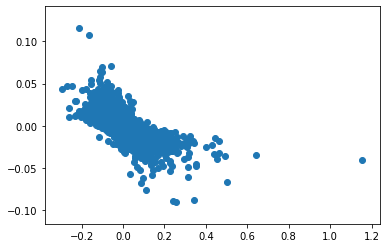

In [187]:
plt.scatter(get_return(D_vix),get_return(D_sp))

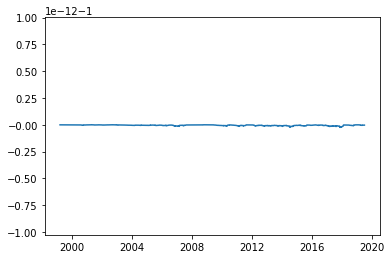

In [188]:
roll_corr=R_sp.rolling(60).corr(R_vix)
roll_corr.dropna()
plt.plot(roll_corr)


### Non linear correlation analysis
compute spearman+ kendall rank correlation

In [189]:
stats.spearmanr(R_sp,R_vix)[0]

-1.0

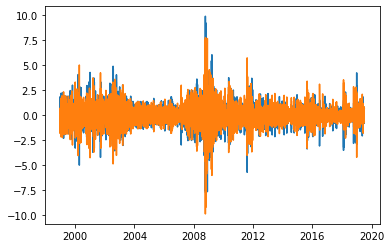

In [190]:

R=pd.concat([R_sp,R_vix],axis=1)
R.columns=['sp','vix']
corr1 = R['sp'].corr(R['vix'],method='kendall', min_periods=1)
corr1
R.columns
R_norm=get_norm(R)
plt.plot(R_norm)

In [ ]:
plt.plot(R,alpha=0.5)


In [ ]:
#in case of normalization
R=R_norm



### pre/post processing


In [10]:
def binarize_multi(data):
    B=[]
    N_var=len(data.columns)
    l=data.columns
    for k in range(N_var):
        X=data[l[k]]
        x_bin,x_int=binarize_1D(X)
        B.append(x_bin)
    B=pd.concat([pd.DataFrame(b) for b in B],axis=1)
    return(B)

def debinarize_multi(data_b,M,m):
    D_n=[]
    N_var=len(M)
    for k in range(N_var):
        d=data_b[ :, 16*k :16*k+16]
        min_d=m[k]
        max_d=M[k]
        d_n=bin_to_float(d,min_d,max_d)
        D_n.append(d_n)
    D_n=pd.concat([pd.DataFrame(b) for b in D_n],axis=1)
    return(D_n)

   


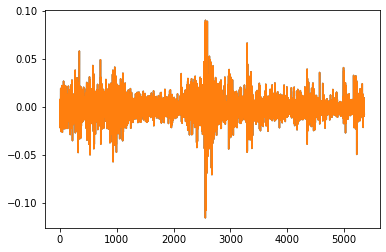

In [192]:
# binarize input
R_b=np.array(binarize_multi(R))       
R_b.shape 

m=list(R.min(axis=0))
Max=list(R.max(axis=0))

# test: debinarize data
R_n=debinarize_multi(R_b,Max,m)        
R_n.columns=R.columns
plt.plot(np.array(R_n['vix']))
R_n=np.array(R_n)
plt.plot(np.array(R['vix']))

In [193]:
#rename variable for RBM execution
B=R_b
M=np.array(R)

batch_size=10
total_batch=int(len(M) / batch_size)


#### resetting the graph

In [198]:

tf.reset_default_graph()

### RBM model for 2D series: definition and training

In [199]:
# Initialize RBM Model for MNIST reconstruction

rbm_model_multi = RBM(n_visible = 2*16, n_hidden = 20, lr = tf.constant(0.05, tf.float32), epochs = 1000, mode='gaussian')
#rbm_model = RBM(n_visible = 784, n_hidden = 144, lr = tf.constant(0.003, tf.float32), epochs = 10000, mode='gaussian')

# Placeholder for the visible layer of the RBM computation graph.
v = tf.placeholder(tf.float32, shape=[None, rbm_model_multi.n_visible], name="visible_layer")

# Update rule
k=1
train_op = rbm_model_multi.update(v, K=k)

# Free energy
energy = rbm_model_multi.free_energy(v=v)
tf.summary.scalar('free_energy', tf.reduce_mean(energy))

# Merge summaries for Tensorboard visualization
summary = tf.summary.merge_all()

# Create session.
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for epoch in tqdm(range(rbm_model_multi.epochs)):
    if epoch % 100 == 0:
        test_set=B
        result = sess.run([rbm_model_multi.rec_error, summary], feed_dict = {v: test_set})
        if epoch % 1000 == 0: print("Reconstruction error at step {}: {:.3f}".format(epoch, result[0]))
        #test_writer.add_summary(result[1],epoch)
    total_batch = int(len(M) / batch_size)
    for i in range(total_batch):
        batchXs=get_random_block_from_data(B, batch_size)
        sess.run(train_op, feed_dict = {v: batchXs})






  0%|          | 0/1000 [00:00<?, ?it/s]

Reconstruction error at step 0: 0.308





  0%|          | 1/1000 [00:00<01:40,  9.98it/s]


  0%|          | 4/1000 [00:00<01:21, 12.25it/s]


  1%|          | 7/1000 [00:00<01:07, 14.66it/s]


  1%|          | 10/1000 [00:00<00:57, 17.13it/s]


  1%|▏         | 13/1000 [00:00<00:52, 18.90it/s]


  2%|▏         | 16/1000 [00:00<00:47, 20.64it/s]


  2%|▏         | 19/1000 [00:00<00:43, 22.76it/s]


  2%|▏         | 22/1000 [00:00<00:40, 23.94it/s]


  2%|▎         | 25/1000 [00:00<00:39, 24.43it/s]


  3%|▎         | 28/1000 [00:01<00:39, 24.74it/s]


  3%|▎         | 31/1000 [00:01<00:38, 25.25it/s]


  3%|▎         | 34/1000 [00:01<00:37, 25.75it/s]


  4%|▎         | 37/1000 [00:01<00:37, 25.81it/s]


  4%|▍         | 40/1000 [00:01<00:36, 25.99it/s]


  4%|▍         | 43/1000 [00:01<00:35, 26.59it/s]


  5%|▍         | 46/1000 [00:01<00:35, 26.86it/s]


  5%|▍         | 49/1000 [00:01<00:35, 27.04it/s]


  5%|▌         | 52/1000 [00:02<00:34, 27.17it/s]


  6%|▌         | 55/1000 [00:02<00:34, 27.35it/s]


  6%|▌      

 93%|█████████▎| 929/1000 [00:37<00:02, 24.43it/s]


 93%|█████████▎| 932/1000 [00:37<00:02, 24.39it/s]


 94%|█████████▎| 935/1000 [00:37<00:02, 24.39it/s]


 94%|█████████▍| 938/1000 [00:37<00:02, 24.42it/s]


 94%|█████████▍| 941/1000 [00:37<00:02, 24.50it/s]


 94%|█████████▍| 944/1000 [00:37<00:02, 24.53it/s]


 95%|█████████▍| 947/1000 [00:37<00:02, 24.45it/s]


 95%|█████████▌| 950/1000 [00:38<00:02, 24.43it/s]


 95%|█████████▌| 953/1000 [00:38<00:01, 24.48it/s]


 96%|█████████▌| 956/1000 [00:38<00:01, 24.48it/s]


 96%|█████████▌| 959/1000 [00:38<00:01, 24.54it/s]


 96%|█████████▌| 962/1000 [00:38<00:01, 24.47it/s]


 96%|█████████▋| 965/1000 [00:38<00:01, 24.47it/s]


 97%|█████████▋| 968/1000 [00:38<00:01, 24.51it/s]


 97%|█████████▋| 971/1000 [00:38<00:01, 24.56it/s]


 97%|█████████▋| 974/1000 [00:39<00:01, 24.21it/s]


 98%|█████████▊| 977/1000 [00:39<00:00, 24.24it/s]


 98%|█████████▊| 980/1000 [00:39<00:00, 24.31it/s]


 98%|█████████▊| 983/1000 [00:39<00:00, 24.39i

In [11]:
def reconstruction_multi(v,steps=1):
    for i in range(steps):
        hidden_p=rbm_model_multi.get_probabilities('hidden', v)
        h_state = sample(hidden_p)
        visible_p=rbm_model_multi.get_probabilities('visible', h_state)
        v=sample(visible_p)
    return(v)

### test: simple sample generation

In [201]:
B_sample=sess.run(reconstruction_multi(v),feed_dict={v: B})
M_sample=debinarize_multi(B_sample,Max,m)

#R_sp,R_vix=R['sp'],R['vix']


In [202]:
M_sample.columns=R.columns
R_sp_fake=M_sample['sp']
R_vix_fake=M_sample['vix']

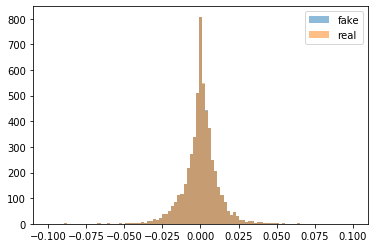

In [203]:

bins = np.linspace(-0.1, 0.1, 100)
plt.hist(R_sp_fake, bins,alpha=0.5,label='fake')[2]
plt.hist(R_sp, bins,alpha=0.5,label='real')[2]
plt.legend()

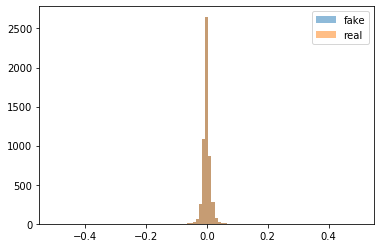

In [204]:
bins = np.linspace(-0.5, 0.5, 100)
plt.hist(R_vix_fake, bins,alpha=0.5,label='fake')[2]
plt.hist(R_vix, bins,alpha=0.5,label='real')[2]
plt.legend()

### correlation test

In [205]:
print(stats.pearsonr(R_sp, R_vix))
print(stats.pearsonr(R_sp_fake, R_vix_fake))

(-1.0, 0.0)
(-0.9999493870795357, 0.0)


In [206]:
print(stats.spearmanr(R_sp, R_vix))
print(stats.spearmanr(R_sp_fake, R_vix_fake))

SpearmanrResult(correlation=-1.0, pvalue=0.0)
SpearmanrResult(correlation=-0.9999774812316189, pvalue=0.0)


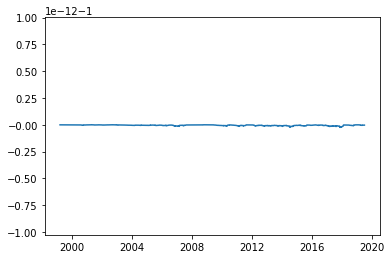

In [207]:
#roll_corr_fake=R_sp_fake.rolling(60).corr(R_vix_fake)
roll_corr=R_sp.rolling(60).corr(R_vix)
roll_corr.dropna()
plt.plot(roll_corr)
#plt.plot(roll_corr_fake)

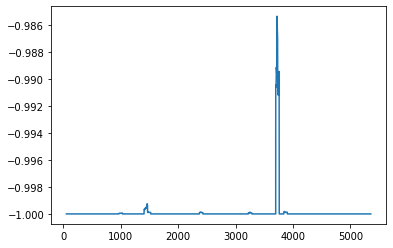

In [208]:
roll_corr_fake=R_sp_fake.rolling(60).corr(R_vix_fake)
roll_corr.dropna()
plt.plot(roll_corr_fake)

### visualisation

In [ ]:
for _ in range(5):
    B_sample=sess.run(reconstruction_multi(v),feed_dict={v: B})
    M_sample=debinarize_multi(B_sample,Max,m)
    u_fake=pd.DataFrame(M_sample)
    u_fake.columns=R.columns
    u_fake.index=R.index
    plt.plot(cumreturn(u_fake['sp']),label='fake')
    
plt.plot(cumreturn(R['sp']),label='true')
plt.legend()


In [ ]:
for _ in range(1):
    B_sample=sess.run(reconstruction_multi(v),feed_dict={v: B})
    M_sample=debinarize_multi(B_sample,Max,m)
    u_fake=pd.DataFrame(M_sample)
    u_fake.columns=R.columns
    u_fake.index=R.index
    plt.plot(cumreturn(u_fake['vix']),label='fake')
    
plt.plot(cumreturn(R['vix']),label='true')
plt.legend()

# other type of data: Pepsi/coca

In [12]:
D_coke=pd.read_csv('KO.csv',index_col='Date',parse_dates=True)
D_coke=D_coke['Adj Close']

D_pep=pd.read_csv('PEP.csv',index_col='Date',parse_dates=True)
D_pep=D_pep['Adj Close']

R_coke=get_return(D_coke)
R_pep=get_return(D_pep)
R_pep.shape



(4777,)

In [13]:
# normalize data: z_score
R_coke=get_norm(R_coke)
R_pep=get_norm(R_pep)


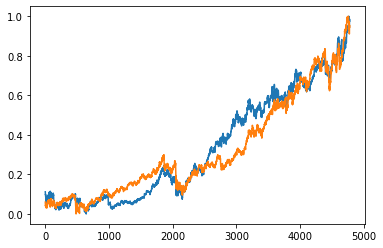

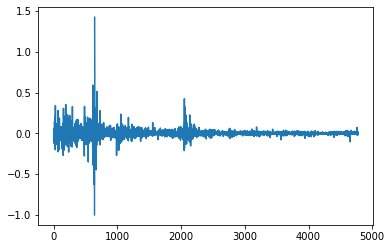

In [216]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(copy=False)
D_coke_n = scaler.fit_transform(np.array(D_coke).reshape(-1, 1))
plt.plot(D_coke_n)

scaler_pep = MinMaxScaler(copy=False)
D_pep_n = scaler_pep.fit_transform(np.array(D_pep).reshape(-1, 1))
plt.plot(D_pep_n)

R_coke=get_return(pd.DataFrame(D_coke_n))
R_pep=get_return(pd.DataFrame(D_pep_n))
R_pep.shape

plt.figure()
plt.plot(R_coke)


### Visualisation + correlation/cointegration analysis

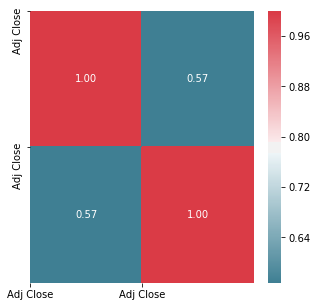

In [14]:
import seaborn as sns

def heatMap(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(5, 5))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.savefig('result_latex/rr')
    
    #show plot
    #plt.show()
  
df_true=pd.concat([R_coke,R_pep],axis=1)    
heatMap(df_true)


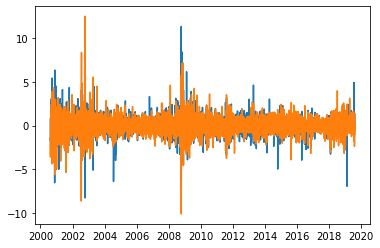

In [264]:
plt.plot(df_true)

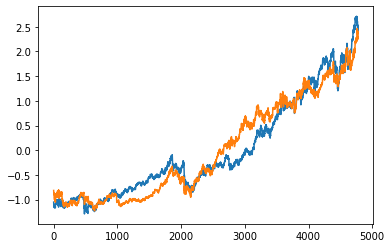

In [217]:
#data are normailzed
plt.plot(np.array(get_norm(D_pep)))
plt.plot(np.array(get_norm(D_coke)))

#stats.pearsonr(R_coke, R_pep)


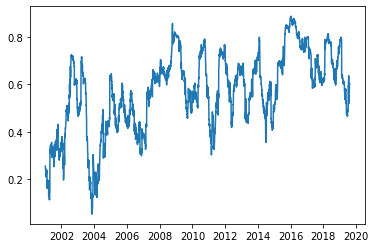

In [222]:
roll_corr=pd.DataFrame(R_coke).rolling(100).corr(pd.DataFrame(R_pep))
roll_corr.dropna()
plt.plot(roll_corr)

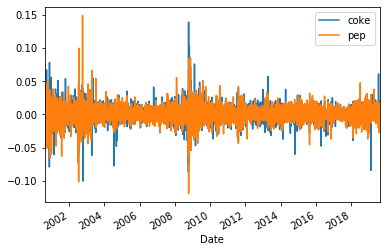

In [223]:

R=pd.concat([R_coke,R_pep],axis=1)
R.columns=['coke','pep']
R.head(2)
R.plot()

### RBM training
#### inputs :
1. fake datas returns
2. real Pep/Coke returns

TypeError: No loop matching the specified signature and casting
was found for ufunc add

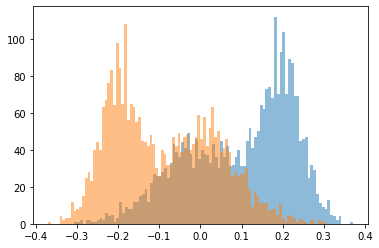

In [15]:
def gauss_mix_multi(N,pi,p_anti):
    sample=[]
    anti_sample=[]
    for i in range(N):
        delta=int(bernoulli.rvs(pi, loc=0, size=1))
        m_1=np.random.normal(0, 0.1, size=1)
        m2=np.random.normal(0.2,0.05 ,size=1)
        mixiture= (1-delta)*m_1+delta*m2
        sample.append(mixiture)
        
        x=int(bernoulli.rvs(p_anti, loc=0, size=1))
        if x==1:
            anti_mixiture=-mixiture
        else:
            anti_mixiture=np.random.normal(0,0.05 ,size=1)
        anti_sample.append(anti_mixiture)
        
    return((np.array(sample),np.array(anti_sample)))

M_1,M_2=gauss_mix_multi(3000,0.5,0.9)
M=pd.concat([pd.DataFrame(M_1),pd.DataFrame(M_2)],axis=1)
M.columns=['1','2']


def aff_histo(m):
    bins = np.linspace(np.min(m), np.max(m), 100)
    plt.hist(m, bins,alpha=0.5)

aff_histo(M_1)
aff_histo(M_2)
print(stats.pearsonr(M_1, M_2))

R_b=np.array(binarize_multi(M))
B=R_b

R=M
R.columns=['coke','pep']
R_coke=R['coke']
R_pep=R['pep']


In [271]:
R_coke=R['coke']
R_pep=R['pep']

(3000, 64)


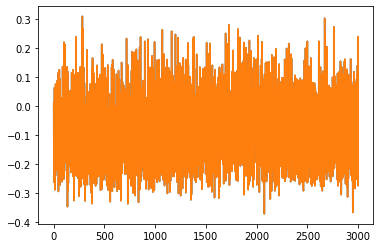

In [272]:
# binarize input
R_b=np.array(binarize_multi(R))
B=R_b
print(R_b.shape) 

m=list(R.min(axis=0))
Max=list(R.max(axis=0))

# test: debinarize data
R_n=debinarize_multi(R_b,Max,m)        
R_n.columns=R.columns
plt.plot(np.array(R_n['pep']))
R_n=np.array(R_n)
plt.plot(np.array(R['pep']))


#### training

In [273]:
batch_size=100
tf.reset_default_graph()
# Initialize RBM Model for MNIST reconstruction
rbm_model_multi = RBM(n_visible = 2*16, n_hidden = 15, lr = tf.constant(0.05, tf.float32), epochs = 1000, mode='bernoulli')
#rbm_model = RBM(n_visible = 784, n_hidden = 144, lr = tf.constant(0.003, tf.float32), epochs = 10000, mode='gaussian')

# Placeholder for the visible layer of the RBM computation graph.
v = tf.placeholder(tf.float32, shape=[None, rbm_model_multi.n_visible], name="visible_layer")

# Update rule
k=1
train_op = rbm_model_multi.update(v, K=k)

# Free energy
energy = rbm_model_multi.free_energy(v=v)
tf.summary.scalar('free_energy', tf.reduce_mean(energy))

# Merge summaries for Tensorboard visualization
summary = tf.summary.merge_all()

# Create session.
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for epoch in tqdm(range(rbm_model_multi.epochs)):
    if epoch % 100 == 0:
        test_set=B
        result = sess.run([rbm_model_multi.rec_error, summary], feed_dict = {v: test_set})
        if epoch % 100 == 0: print("Reconstruction error at step {}: {:.3f}".format(epoch, result[0]))
        #test_writer.add_summary(result[1],epoch)
    total_batch = int(len(B) / batch_size)
    for i in range(total_batch):
        batchXs=get_random_block_from_data(B, batch_size)
        sess.run(train_op, feed_dict = {v: batchXs})



  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: Cannot feed value of shape (3000, 64) for Tensor 'visible_layer:0', which has shape '(?, 32)'

In [230]:
#permet de faire un seul aller-retour dans le reseau
def reconstruction_multi(v,steps=1):
    for i in range(steps):
        hidden_p=rbm_model_multi.get_probabilities('hidden', v)
        h_state = sample(hidden_p)
        #h_state=hidden_p
        visible_p=rbm_model_multi.get_probabilities('visible', h_state)
        v=sample(visible_p)
        #v=visible_p
    #v=sample(v)
    return(v)

## Input reconstruction

In [231]:
B_sample=sess.run(reconstruction_multi(v,steps=10),feed_dict={v: B})
m=list(R.min(axis=0))
Max=list(R.max(axis=0))
M_sample=debinarize_multi(B_sample,Max,m)

M_sample.columns=R.columns
R_coke_fake=M_sample['coke']
R_pep_fake=M_sample['pep']

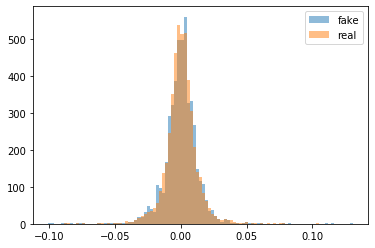

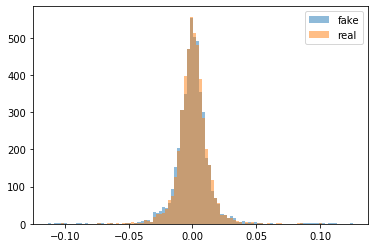

In [232]:
plt.figure()
bins = np.linspace(np.min(R_coke_fake), np.max(R_coke_fake), 100)
plt.hist(R_coke_fake, bins,alpha=0.5,label='fake')[2]
plt.hist(R['coke'], bins,alpha=0.5,label='real')[2]
plt.legend()

plt.figure()
bins = np.linspace(np.min(R_pep_fake), np.max(R_pep_fake), 100)
plt.hist(R_pep_fake, bins,alpha=0.5,label='fake')[2]
plt.hist(R['pep'], bins,alpha=0.5,label='real')[2]
plt.legend()

In [223]:
print(stats.pearsonr(R_coke, R_pep))
print(stats.pearsonr(R_coke_fake, R_pep_fake))

(-0.9246506053663484, 0.0)
(-0.15113589231683888, 8.616255333884082e-17)


In [224]:
print(stats.spearmanr(R_coke, R_pep))
print(stats.spearmanr(R_coke_fake, R_pep_fake))

SpearmanrResult(correlation=-0.9191739083526563, pvalue=0.0)
SpearmanrResult(correlation=-0.2408037066367161, pvalue=7.783748224917631e-41)


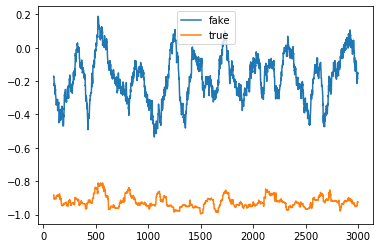

In [217]:
R_coke_fake=pd.DataFrame(R_coke_fake)
R_coke_fake.index=R_coke.index

R_pep_fake=pd.DataFrame(R_pep_fake)
R_pep_fake.index=R_pep.index


R_c=R_coke_fake['coke']
R_p=R_pep_fake['pep']
roll_corr_f=R_c.rolling(100).corr(R_p)
roll_corr=R_coke.rolling(100).corr(R_pep)

roll_corr.dropna()
plt.plot(roll_corr_f,label='fake')
plt.plot(roll_corr,label='true')
plt.legend()

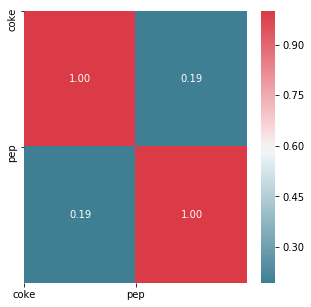

In [233]:
df_fake=pd.concat([R_coke_fake,R_pep_fake],axis=1)    
heatMap(df_fake)

### Thermalisation: inputs generation

In [241]:
m_1=np.random.normal(0,1, size=R.shape[0])
m_2=np.random.normal(0,1, size=R.shape[0])
N=pd.concat([pd.Series(m_1),pd.Series(m_2)],axis=1)

# binarize input
N_b=np.array(binarize_multi(N))
B_noise=N_b
print(N_b.shape) 
m

(4777, 32)


[-0.1006094324321436, -0.11931368424584521]

In [245]:
B_sample_1=sess.run(reconstruction_multi(v,steps=10000),feed_dict={v: B_noise})
M_sample_1=debinarize_multi(B_sample_1,m,Max)

M_sample_1.columns=R.columns
R_coke_fake=M_sample_1['coke']
R_pep_fake=M_sample_1['pep']


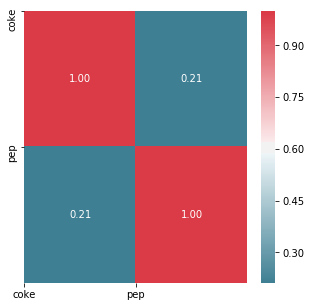

In [246]:
heatMap(M_sample_1)

## N-multidimensionnal series

In [32]:
data_sp=pd.read_csv('prixSPX')
prices=data_sp
prices_clean=prices.dropna(axis=1)
prices_clean.columns=[str(i) for i in range(115)]
prices_clean.index=prices_clean['0']

prix=prices_clean[[str(i) for i in range(1,50)]]


prix=prix[[str(i) for i in range(1,5)]]

In [64]:
L=[]
M=[]
S=[]
for x in prix.columns:
    #r=get_norm(get_return(prix[x]))
    r=get_return(prix[x])
    L.append(r)
    M.append(mu)
    S.append(sig)

R=pd.concat([L[i] for i in range(len(L))],axis=1)
R.columns=prix.columns    

R_clean=R.iloc[:3826]

R_b=np.array(binarize_multi(R_clean))
B=R_b






In [65]:
type(R)
R.head(2)
R.shape



(4589, 4)

W0913 10:05:31.709831  7364 legend.py:1282] No handles with labels found to put in legend.


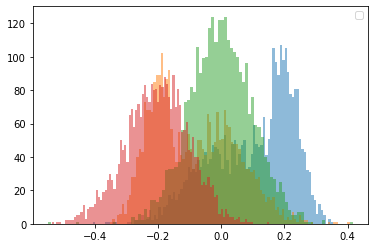

In [19]:
def gauss_mix_multi(N,pi,p_anti):
    sample=[]
    anti_sample=[]
    for i in range(N):
        delta=int(bernoulli.rvs(pi, loc=0, size=1))
        m_1=np.random.normal(0, 0.1, size=1)
        m2=np.random.normal(0.2,0.05 ,size=1)
        mixiture= (1-delta)*m_1+delta*m2
        sample.append(mixiture)
        
        x=int(bernoulli.rvs(p_anti, loc=0, size=1))
        if x==1:
            anti_mixiture=-mixiture
        else:
            anti_mixiture=np.random.normal(0,0.05 ,size=1)
        anti_sample.append(anti_mixiture)
    normal_1=np.random.normal(0, 0.1, size=N)
    normal_2=np.random.normal(-0.2, 0.1, size=N)
        
    return((np.array(sample),np.array(anti_sample),np.array(normal_1),normal_2))

M_1,M_2,M_3,M_4=gauss_mix_multi(3000,0.5,0.9)
M=pd.concat([pd.DataFrame(M_1),pd.DataFrame(M_2),pd.DataFrame(M_3),pd.DataFrame(M_4)],axis=1)
M.columns=[str(i) for i in range(4)]


def aff_histo(m):
    bins = np.linspace(np.min(m), np.max(m), 100)
    plt.hist(m, bins,alpha=0.5)

for k in range(4):
    aff_histo(M[str(k)])


R_b=np.array(binarize_multi(M))
B=R_b

R=M
R.columns=['coke','pep','apple','micro']
R_coke=R['coke']
R_pep=R['pep']
R_a=R['apple']
R_m=['micro']

plt.legend()

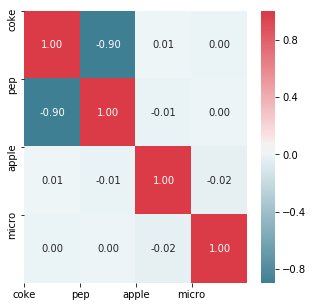

In [47]:
heatMap(R)


In [52]:
B.shape

(3826, 64)

In [66]:
batch_size=10
tf.reset_default_graph()
# Initialize RBM Model for MNIST reconstruction
rbm_model_multi = RBM(n_visible = 4*16, n_hidden = 30, lr = tf.constant(0.05, tf.float32), epochs = 1500,mode='bernoulli')
#rbm_model = RBM(n_visible = 784, n_hidden = 144, lr = tf.constant(0.003, tf.float32), epochs = 10000, mode='gaussian')

# Placeholder for the visible layer of the RBM computation graph.
v = tf.placeholder(tf.float32, shape=[None, rbm_model_multi.n_visible], name="visible_layer")

# Update rule
k=1
train_op = rbm_model_multi.update(v, K=k)

# Free energy
energy = rbm_model_multi.free_energy(v=v)
tf.summary.scalar('free_energy', tf.reduce_mean(energy))

# Merge summaries for Tensorboard visualization
summary = tf.summary.merge_all()

# Create session.
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for epoch in tqdm(range(rbm_model_multi.epochs)):
    if epoch % 100 == 0:
        test_set=B
        result = sess.run([rbm_model_multi.rec_error, summary], feed_dict = {v: test_set})
        if epoch % 100 == 0: print("Reconstruction error at step {}: {:.3f}".format(epoch, result[0]))
        #test_writer.add_summary(result[1],epoch)
    total_batch = int(len(B) / batch_size)
    for i in range(total_batch):
        batchXs=get_random_block_from_data(B, batch_size)
        sess.run(train_op, feed_dict = {v: batchXs})

  0%|          | 0/1500 [00:00<?, ?it/s]

Reconstruction error at step 0: 0.300


  7%|▋         | 100/1500 [00:11<02:42,  8.62it/s]

Reconstruction error at step 100: 0.126


 13%|█▎        | 200/1500 [00:23<02:40,  8.11it/s]

Reconstruction error at step 200: 0.109


 20%|█▉        | 299/1500 [00:34<02:13,  8.98it/s]

Reconstruction error at step 300: 0.106


 27%|██▋       | 400/1500 [00:45<01:48, 10.14it/s]

Reconstruction error at step 400: 0.105


 33%|███▎      | 500/1500 [00:55<01:34, 10.62it/s]

Reconstruction error at step 500: 0.104


 40%|████      | 600/1500 [01:04<01:28, 10.22it/s]

Reconstruction error at step 600: 0.104


 47%|████▋     | 700/1500 [01:13<01:13, 10.87it/s]

Reconstruction error at step 700: 0.104


 53%|█████▎    | 800/1500 [01:23<01:04, 10.90it/s]

Reconstruction error at step 800: 0.104


 60%|█████▉    | 899/1500 [01:33<00:56, 10.55it/s]

Reconstruction error at step 900: 0.104


 67%|██████▋   | 1000/1500 [01:42<00:45, 11.04it/s]

Reconstruction error at step 1000: 0.104


 73%|███████▎  | 1099/1500 [01:51<00:34, 11.61it/s]

Reconstruction error at step 1100: 0.104


 80%|███████▉  | 1199/1500 [02:00<00:26, 11.38it/s]

Reconstruction error at step 1200: 0.103


 87%|████████▋ | 1299/1500 [02:11<00:20,  9.95it/s]

Reconstruction error at step 1300: 0.103


 93%|█████████▎| 1400/1500 [02:21<00:08, 11.38it/s]

Reconstruction error at step 1400: 0.103


100%|██████████| 1500/1500 [02:30<00:00, 11.05it/s]


In [67]:
B_sample=sess.run(reconstruction_multi(v,steps=1),feed_dict={v: B})
m=list(R.min(axis=0))
Max=list(R.max(axis=0))
M_sample=debinarize_multi(B_sample,Max,m)

R.columns=['coke','pep','apple','micro']
M_sample.columns=R.columns
R_coke_fake=M_sample['coke']
R_pep_fake=M_sample['pep']
R_a_fake=M_sample['apple']
R_m_fake=M_sample['micro']

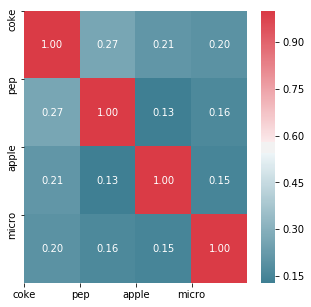

In [70]:
heatMap(M_sample)
#heatMap(pd.DataFrame(R_clean))


In [82]:
print(np.percentile(R_m_fake, 1))
print(np.percentile(R_clean['4'], 1))


-0.07610846740036846
-0.06802438274786238


In [ ]:
print(np.percentile(, 1))
print(np.percentile(M_sample_1, 1))
print(np.percentile(m_1, 1))
print(np.percentile(M_t, 99))
print(np.percentile(M_sample_1, 99))
print(np.percentile(m_1, 99))

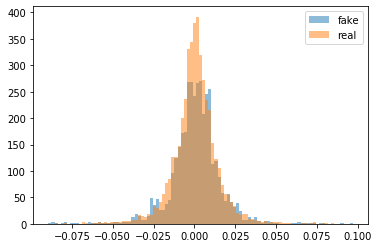

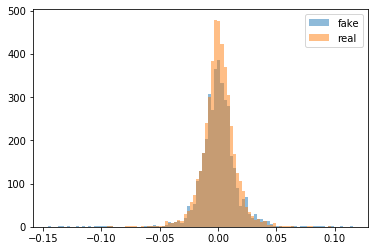

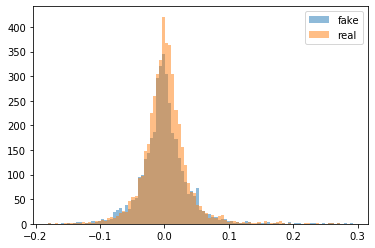

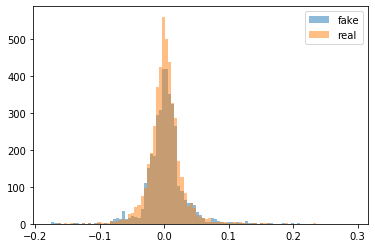

In [69]:
plt.figure()
bins = np.linspace(np.min(R_coke_fake), np.max(R_coke_fake), 100)
plt.hist(R_coke_fake, bins,alpha=0.5,label='fake')[2]
plt.hist(R['coke'], bins,alpha=0.5,label='real')[2]
plt.savefig('result_latex/hist_1.png')
plt.legend()

plt.figure()
bins = np.linspace(np.min(R_pep_fake), np.max(R_pep_fake), 100)
plt.hist(R_pep_fake, bins,alpha=0.5,label='fake')[2]
plt.hist(R['pep'], bins,alpha=0.5,label='real')[2]
plt.savefig('result_latex/hist_2.png')
plt.legend()

plt.figure()
bins = np.linspace(np.min(R_a_fake), np.max(R_a_fake), 100)
plt.hist(R_a_fake, bins,alpha=0.5,label='fake')[2]
plt.hist(R['apple'], bins,alpha=0.5,label='real')[2]
plt.savefig('result_latex/hist_3.png')
plt.legend()

plt.figure()
bins = np.linspace(np.min(R_a_fake), np.max(R_a_fake), 100)
plt.hist(R_m_fake, bins,alpha=0.5,label='fake')[2]
plt.hist(R['micro'], bins,alpha=0.5,label='real')[2]
plt.savefig('result_latex/hist_4.png')
plt.legend()



In [62]:
print(stats.pearsonr(R_coke, R_pep))
print(stats.pearsonr(R_coke_fake, R_pep_fake))

(-0.9144810456830212, 0.0)
(0.18370172852734612, 2.1759221657388732e-30)


In [63]:
print(stats.pearsonr(R_coke, R['apple']))
print(stats.pearsonr(R_coke_fake, R_a_fake))

ValueError: x and y must have the same length.

## remarks
1. Gaussian mode -- with multi-dim series// Bernouill mode: ++
2. increase hidden neurons: no effect on correlation (very little improvment)
3. CD_10 no significant improvment comparing to CD_1, CD_100 on 100 iteration: no improvment
4. generate sample after training with 10,100,1000 forward-backward pass: no significant improvment corr=0.2// try to use gaussian mode: no improvment as well
5. 2D (1 mixiture + 1 anti_correlated fake mixiture) work well: RBM able to capture correlation structure)
6. 4D (latest 2D + 2 normal distrib) work well: RBM able to capture corr struture
7. z-score des returns: improvement corr=0.36 instead of 0.5

## Using RBM library: checking

In [248]:
from sklearn.neural_network import BernoulliRBM
X=R
rbm = BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=2, n_iter=1000,
       random_state=None, verbose=0)
rbm.fit(X)  



BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=2, n_iter=1000,
             random_state=None, verbose=0)

In [246]:
R.shape

(4777, 2)

# Conditionnal RBM

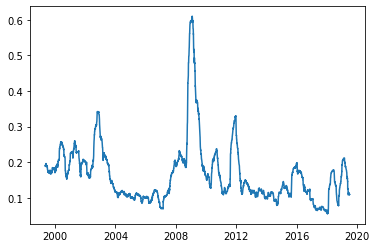

In [103]:
R_sp=get_return(D_sp)
roll_std=R_sp.rolling(100).std()*(np.sqrt(252))
plt.plot(roll_std)

In [105]:
ret_fx.std()*(np.sqrt(252))

0.0968774290756277

(array([-0.53493632]), array([0.]))


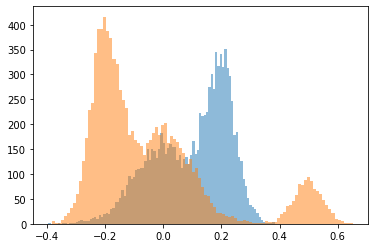

In [157]:
def gauss_mix_multi(N,pi,p_anti):
    sample=[]
    anti_sample=[]
    for i in range(N):
        delta=int(bernoulli.rvs(pi, loc=0, size=1))
        m_1=np.random.normal(0, 0.1, size=1)
        m2=np.random.normal(0.2,0.05 ,size=1)
        mixiture= (1-delta)*m_1+delta*m2
        sample.append(mixiture)
        
        x=int(bernoulli.rvs(p_anti, loc=0, size=1))
        if x==1:
            anti_mixiture=-mixiture
        else:
            anti_mixiture=np.random.normal(0.5,0.05 ,size=1)
        anti_sample.append(anti_mixiture)
        
    return((np.array(sample),np.array(anti_sample)))

M_1,M_2=gauss_mix_multi(10000,0.5,0.9)
M=pd.concat([pd.DataFrame(M_1),pd.DataFrame(M_2)],axis=1)
M.columns=['1','2']

def aff_histo(m):
    bins = np.linspace(np.min(m), np.max(m), 100)
    plt.hist(m, bins,alpha=0.5)

aff_histo(M_1)
aff_histo(M_2)
print(stats.pearsonr(M_1, M_2))